# ML2 Semestral Project - Football O/U 2.5
**Authors:** Phuong Nhi Tranová, Vít Maruniak, Šimon Slánský, Radim Škoukal, Ondřej Zetek, Martin Kareš, Jan Korčák, Jakub Maličkay, Jáchym Janouch  
**Course:** FIS 4IT344 Machine Learning 2 (2025/2026)  
**Goal:** Compare baseline (current features) vs extended (richer features) models for O/U 2.5 goals across markets; translate accuracy gains into optimal profit and **maximum data subscription price per country** *.  



---


***maximum data subscription price per country**
- the most money our company should be willing to pay for that country's additional data
- that's how much extra profit the improved model generates
- baseline model → accuracy = A₀
    - Generates profit Π*(A₀)
- extended model → accuracy = A₁
    - Generates profit Π*(A₁)
- profit improvement = ΔΠ = Π(A₁) − Π(A₀)*
    - basically how much more money the comany earns each year by using the better data
- the maximum data subscription price per country = ΔΠ


# 0. Imports and paths

### 0.1 Imports

In [1]:
import os, glob, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import zscore, chi2_contingency
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


### 0.2 Library parameters

In [2]:
plt.rcParams["figure.figsize"] = (8,5)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 0.3 Paths

In [3]:
DATA_DIR = "./data"
OUTPUT_DIR = f"./processed"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Data load

In [4]:
def load_all_matches(data_dir: str) -> pd.DataFrame:
    csv_files = glob.glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found under {data_dir}")

    frames = []
    for fp in csv_files:
        # extract path info
        rel = os.path.relpath(fp, data_dir)
        parts = Path(rel).parts
        country = parts[0] if len(parts) >= 1 else None
        league  = parts[1] if len(parts) >= 2 else None
        season_file = parts[2] if len(parts) >= 3 else None
        season_code = os.path.splitext(season_file)[0] if season_file else None

        # read and rename
        try:
            df = pd.read_csv(fp, low_memory=False)
        except Exception as e:
            print(f"Skipping {fp}: {e}")
            continue

        # Format season as YYYY/YYYY format
        if season_code and len(season_code) == 4 and season_code.isdigit():
            # Handle formats like "1920" or "2021"
            year1 = int(season_code[:2])
            year2 = int(season_code[2:])

            # Determine century based on year range
            if year1 >= 19 and year1 <= 24:  # 19-24 maps to 2019-2024
                year1_full = 2000 + year1
            else:
                year1_full = 1900 + year1

            if year2 >= 19 and year2 <= 99:
                if year2 < year1:  # Next year (e.g., 19->20, 23->24)
                    year2_full = 2000 + year2
                else:
                    year2_full = 2000 + year2
            else:
                year2_full = 1900 + year2

            season_formatted = f"{year1_full}/{year2_full}"
        else:
            season_formatted = season_code  # Fallback to original if format is unexpected

        # Add Season column right after Div (if Div exists)
        if 'Div' in df.columns:
            div_idx = df.columns.get_loc('Div')
            df.insert(div_idx + 1, 'Season', season_formatted)
        else:
            df['Season'] = season_formatted

        frames.append(df)

    all_df = pd.concat(frames, ignore_index=True, sort=False)
    return all_df

# run the loader
all_matches = pd.DataFrame(load_all_matches(DATA_DIR))
print(all_matches.columns.tolist())
print(all_matches.shape)
display(all_matches.head())

['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'BFH', 'BFD', 'BFA', '1XBH', '1XBD', '1XBA', 'BFEH', 'BFED', 'BFEA',

,Div,Season,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFH,BFD,BFA,1XBH,1XBD,1XBA,BFEH,BFED,BFEA,BFE>2.5,BFE<2.5,BFEAHH,BFEAHA,BFCH,BFCD,BFCA,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA,Unnamed: 105,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 106
0,E0,2021/2022,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1.0,0.0,H,M Oliver,8.0,22.0,3.0,4.0,12.0,8.0,2.0,5.0,0.0,0.0,0.0,0.0,4.00,3.40,1.95,4.00,3.50,1.95,3.80,3.40,2.05,4.05,3.46,2.05,4.00,3.40,1.90,4.10,3.40,2.00,4.62,3.72,2.10,4.02,3.43,2.02,2.10,1.72,2.22,1.73,2.26,1.83,2.16,1.73,0.50,1.86,2.07,1.88,2.06,2.05,2.08,1.87,2.03,3.8,3.25,2.05,3.80,3.3,2.05,3.80,3.25,2.10,3.94,3.33,2.13,3.90,3.00,2.05,3.90,3.25,2.10,4.20,3.50,2.18,3.89,3.28,2.10,2.37,1.57,2.44,1.62,2.47,1.75,2.33,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2021/2022,14/08/2021,12:30,Man United,Leeds,5,1,H,1.0,0.0,H,P Tierney,16.0,10.0,8.0,3.0,11.0,9.0,5.0,4.0,1.0,2.0,0.0,0.0,1.53,4.50,5.75,1.53,4.50,5.75,1.55,4.40,5.75,1.56,4.57,5.96,1.52,4.33,5.80,1.55,4.40,6.00,1.59,4.65,6.35,1.55,4.48,5.87,1.61,2.30,1.67,2.32,1.71,2.38,1.65,2.29,-1.00,1.95,1.98,1.96,1.96,2.00,2.01,1.93,1.96,1.61,4.20,5.25,1.62,4.1,5.25,1.65,4.20,4.90,1.67,4.20,5.40,1.57,4.20,5.50,1.65,4.10,5.25,1.71,4.33,5.80,1.64,4.19,5.22,1.66,2.20,1.70,2.27,1.75,2.37,1.67,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2021/2022,14/08/2021,15:00,Burnley,Brighton,1,2,A,1.0,0.0,H,D Coote,14.0,14.0,3.0,8.0,10.0,7.0,7.0,6.0,2.0,1.0,0.0,0.0,3.10,3.10,2.45,3.20,3.10,2.40,3.15,3.05,2.45,3.30,3.12,2.51,3.20,3.00,2.45,3.13,3.10,2.45,3.33,3.20,2.60,3.19,3.09,2.49,2.50,1.53,2.56,1.56,2.56,1.63,2.46,1.57,0.25,1.80,2.14,1.83,2.12,1.83,2.17,1.79,2.12,3.1,3.10,2.45,3.25,3.1,2.4,3.10,3.05,2.45,3.27,3.14,2.51,3.10,3.00,2.45,3.13,3.13,2.50,3.35,3.20,2.56,3.19,3.10,2.48,2.30,1.61,2.33,1.67,2.42,1.71,2.34,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2021/2022,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2.0,0.0,H,J Moss,13.0,4.0,6.0,1.0,15.0,11.0,5.0,2.0,0.0,0.0,0.0,0.0,1.25,5.75,13.00,1.28,5.75,10.50,1.25,6.00,13.00,1.26,6.24,12.74,1.25,5.50,13.00,1.25,5.75,13.00,1.30,6.30,15.00,1.26,5.92,12.80,1.80,2.00,1.80,2.09,1.84,2.12,1.79,2.06,-1.50,1.84,2.09,1.79,2.12,1.93,2.12,1.83,2.07,1.3,5.25,11.00,1.33,5.0,10.0,1.30,5.25,11.00,1.34,5.40,11.00,1.30,5.25,10.00,1.33,5.00,11.00,1.36,5.50,11.50,1.33,5.17,10.58,1.90,1.90,1.93,1.98,1.96,2.07,1.90,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2021/2022,14/08/2021,15:00,Everton,Southampton,3,1,H,0.0,1.0,A,A Madley,14.0,6.0,6.0,3.0,13.0,15.0,6.0,8.0,2.0,0.0,0.0,0.0,1.90,3.50,4.00,1.95,3.50,3.90,1.95,3.45,3.95,2.01,3.56,4.10,1.95,3.40,4.00,1.95,3.40,4.10,2.04,3.66,4.25,1.97,3.53,4.04,2.00,1.80,2.14,1.78,2.14,1.85,2.07,1.79,-0.50,2.00,1.93,2.01,1.92,2.01,1.97,1.96,1.92,2.0,3.40,3.90,2.05,3.4,3.75,2.00,3.35,4.00,2.05,3.45,4.07,1.95,3.40,3.90,2.00,3.30,4.20,2.12,3.50,4.20,2.04,3.39,3.95,2.20,1.66,2.28,1.69,2.34,1.77,2.24,1.67,-0.50,2.05,1.88,2.05,1.8

# 2. Exploratory Data Analysis

Before proceeding with data cleaning, let's understand our data better through comprehensive exploratory data analysis. This will help us make informed decisions about preprocessing steps.

### 2.1 Data Shape and Overview

In [5]:
print(f"Dataset shape: {all_matches.shape}")
print(f"Number of seasons/countries covered:")
print(f"Countries: {all_matches['Div'].str[:-1].nunique()}")
print(f"Leagues: {all_matches['Div'].nunique()}")
print(f"Date range: {all_matches['Date'].min()} to {all_matches['Date'].max()}")

# Check basic statistics
print(f"\nBasic goal statistics:")
print(f"Total goals per match stats:")
total_goals = all_matches['FTHG'] + all_matches['FTAG']
print(total_goals.describe())

print(f"\nOver/Under 2.5 goals distribution:")
over_2_5 = (total_goals > 2.5).astype(int)
print(f"Over 2.5: {over_2_5.sum()} ({over_2_5.mean():.2%})")
print(f"Under 2.5: {(~over_2_5.astype(bool)).sum()} ({(1-over_2_5.mean()):.2%})")

Dataset shape: (42593, 138)
Number of seasons/countries covered:
Countries: 11
Leagues: 21
Date range: 01/01/2020 to 31/12/2024

Basic goal statistics:
Total goals per match stats:
count    42593.000000
mean         2.666800
std          1.643059
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         13.000000
dtype: float64

Over/Under 2.5 goals distribution:
Over 2.5: 21292 (49.99%)
Under 2.5: 21301 (50.01%)


Great! Our target variable (Over/Under 2.5 goals) is perfectly balanced with almost exactly 50/50 split, which is ideal for classification. Mainly because the model won't be biased toward either class and we can use standard accuracy but also because we won't have to do any kind of resampling or rebalancing techniques.

### 2.2 Missing Values Analysis

In [6]:
# Detailed missing values analysis
missing_analysis = pd.DataFrame({
    'column': all_matches.columns,
    'missing_count': all_matches.isnull().sum(),
    'missing_percentage': (all_matches.isnull().sum() / len(all_matches)) * 100,
    'dtype': all_matches.dtypes
})

# Filter to show only columns with missing values
missing_analysis = missing_analysis[missing_analysis['missing_count'] > 0].sort_values('missing_percentage', ascending=False)

print(f"Columns with missing values: {len(missing_analysis)}")
print(f"Total columns: {len(all_matches.columns)}")
print(f"\nTop 20 columns with highest missing percentage:")
display(missing_analysis.head(20))

# Check missing patterns in key variables
key_stats = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
print(f"\nMissing data in key match statistics:")
for stat in key_stats:
    if stat in all_matches.columns:
        missing_pct = (all_matches[stat].isnull().sum() / len(all_matches)) * 100
        print(f"{stat}: {missing_pct:.1f}%")

Columns with missing values: 129
Total columns: 138

Top 20 columns with highest missing percentage:


,column,missing_count,missing_percentage,dtype
Unnamed: 106,Unnamed: 106,42593,100.000000,float64
Unnamed: 105,Unnamed: 105,42593,100.000000,float64
Unnamed: 121,Unnamed: 121,42593,100.000000,float64
Unnamed: 120,Unnamed: 120,42593,100.000000,float64
Unnamed: 119,Unnamed: 119,42593,100.000000,float64
BFEAHA,BFEAHA,36701,86.166741,float64
BFEAHH,BFEAHH,36701,86.166741,float64
BFE>2.5,BFE>2.5,35797,84.044327,float64
BFE<2.5,BFE<2.5,35797,84.044327,float64
1XBH,1XBH,35638,83.671026,object



Missing data in key match statistics:
HS: 0.1%
AS: 0.1%
HST: 0.1%
AST: 0.1%
HF: 0.1%
AF: 0.1%
HC: 0.1%
AC: 0.1%
HY: 0.1%
AY: 0.1%
HR: 0.1%
AR: 0.1%


The missing data analysis reveals that:
1. **Betting odds** have the highest missing percentages (80%+) - this is expected as not all bookmakers operate in all leagues/seasons
2. **Key match statistics** (shots, corners, fouls, cards) have very low missing rates (<0.1%), which is excellent for our modeling
3. Most missing data is in betting-related columns, which we can handle appropriately

also we have found 4 unnamed columns that are 100% missing. they're most likely artifacts from csv exports so they're definitely safe to drop outright

lets do a bit more of a in depth analysis, shall we?

In [7]:
raw = all_matches.copy()

# missingness flag
stats_cols = ['HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']
for c in stats_cols:
    if c in raw.columns:
        raw[f'isna_{c}'] = raw[c].isna().astype(int)

# Row-level summary: how many of the 12 stats are missing in the same row?
flag_cols = [f'isna_{c}' for c in stats_cols if f'isna_{c}' in raw.columns]
raw['missing_count_stats'] = raw[flag_cols].sum(axis=1)

# Quick overview
print(raw['missing_count_stats'].value_counts().sort_index())


missing_count_stats
0     42547
2         2
8         3
12       41
Name: count, dtype: int64


Most of the rows seem to have no missigness/ However, there are 41 rows that have are missing all 12 variables, which seems pretty clustered. Suggesting that the missing data likely stem from a specific data source or a batch issue rather than random omission.

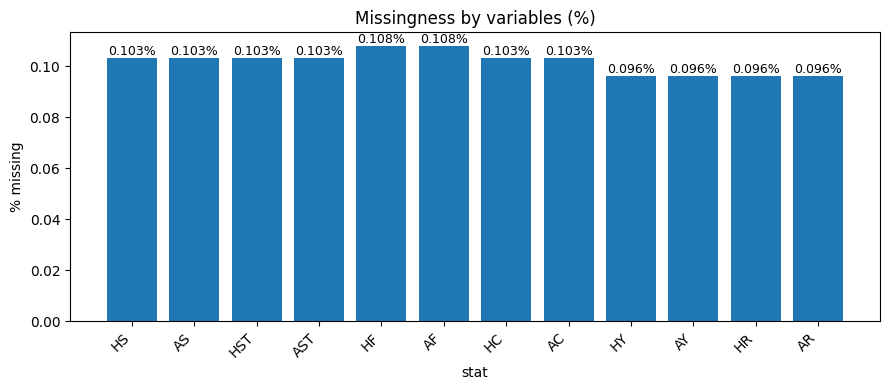

In [8]:
# single-stat missing % (already computed as flags)
single_rates = (raw[flag_cols].mean() * 100)
single_rates.index = [c.replace('isna_', '') for c in single_rates.index]

fig, ax = plt.subplots(figsize=(9,4))
ax.bar(single_rates.index, single_rates.values)
ax.set_title('Missingness by variables (%)')
ax.set_ylabel('% missing')
ax.set_xlabel('stat')
ax.set_xticklabels(single_rates.index, rotation=45, ha='right')
for i, v in enumerate(single_rates.values):
    ax.text(i, v, f'{v:.3f}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

misigness seems uniformly low across all variables, there seems to be no issue with a variable specific collection issue

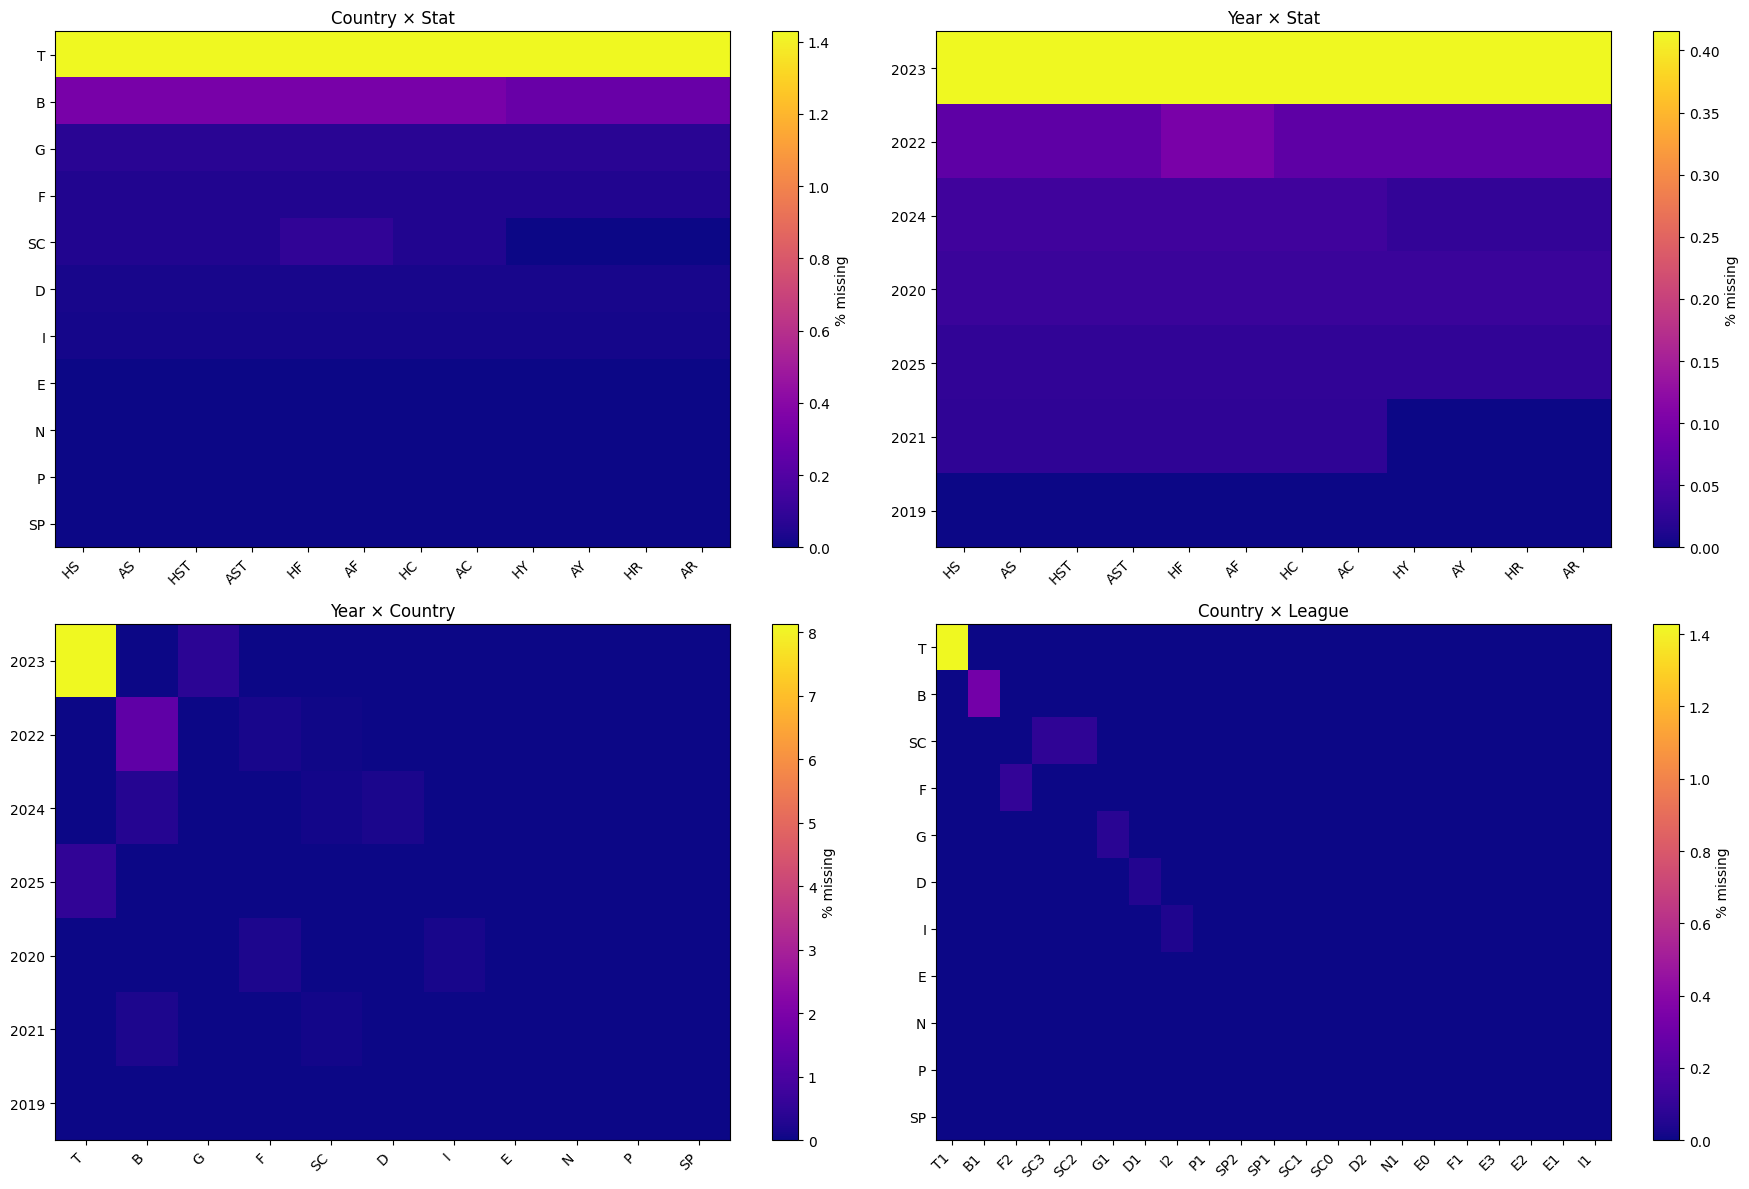

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()
cmap = 'plasma'

# Extract country from Div column (e.g., 'E1' -> 'E', 'SP2' -> 'SP')
raw['country_code'] = raw['Div'].str[:-1]

# 1️⃣ Country × Stat
if 'country_code' in raw.columns:
    M1 = raw.groupby('country_code')[flag_cols].mean().mul(100)
    order = M1.mean(axis=1).sort_values(ascending=False).index
    M1 = M1.loc[order]
    M1.columns = [c.replace('isna_', '') for c in M1.columns]

    im1 = axes[0].imshow(M1.values, aspect='auto', cmap=cmap)
    axes[0].set_xticks(np.arange(M1.shape[1]))
    axes[0].set_xticklabels(M1.columns, rotation=45, ha='right')
    axes[0].set_yticks(np.arange(M1.shape[0]))
    axes[0].set_yticklabels(M1.index)
    axes[0].set_title('Country × Stat')
    fig.colorbar(im1, ax=axes[0], label='% missing')
else:
    axes[0].text(0.5, 0.5, "Missing 'Div' column", ha='center', va='center')
    axes[0].set_axis_off()

# 2️⃣ Year × Stat (using Date column)
if 'Date' in raw.columns:
    raw['year'] = pd.to_datetime(raw['Date']).dt.year
    M2 = raw.groupby('year')[flag_cols].mean().mul(100)
    order = M2.mean(axis=1).sort_values(ascending=False).index
    M2 = M2.loc[order]
    M2.columns = [c.replace('isna_', '') for c in M2.columns]

    im2 = axes[1].imshow(M2.values, aspect='auto', cmap=cmap)
    axes[1].set_xticks(np.arange(M2.shape[1]))
    axes[1].set_xticklabels(M2.columns, rotation=45, ha='right')
    axes[1].set_yticks(np.arange(M2.shape[0]))
    axes[1].set_yticklabels(M2.index.astype(int))
    axes[1].set_title('Year × Stat')
    fig.colorbar(im2, ax=axes[1], label='% missing')
else:
    axes[1].text(0.5, 0.5, "Missing 'Date' column", ha='center', va='center')
    axes[1].set_axis_off()

# 3️⃣ Year × Country
needed = {'year', 'country_code'}
if needed.issubset(raw.columns):
    G = raw.groupby(['year','country_code'])[flag_cols].mean().mul(100)
    G['avg_missing'] = G.mean(axis=1)
    year_order  = G['avg_missing'].groupby(level=0).mean().sort_values(ascending=False).index
    country_order = G['avg_missing'].groupby(level=1).mean().sort_values(ascending=False).index
    P3 = (G['avg_missing'].unstack('country_code')
          .reindex(index=year_order, columns=country_order)
          .fillna(0))

    im3 = axes[2].imshow(P3.values, aspect='auto', cmap=cmap)
    axes[2].set_xticks(np.arange(P3.shape[1]))
    axes[2].set_xticklabels(P3.columns, rotation=45, ha='right')
    axes[2].set_yticks(np.arange(P3.shape[0]))
    axes[2].set_yticklabels(P3.index.astype(int))
    axes[2].set_title('Year × Country')
    fig.colorbar(im3, ax=axes[2], label='% missing')
else:
    axes[2].text(0.5, 0.5, "Missing required columns", ha='center', va='center')
    axes[2].set_axis_off()

# 4️⃣ Country × League
needed = {'country_code', 'Div'}
if needed.issubset(raw.columns):
    G = raw.groupby(['country_code', 'Div'])[flag_cols].mean().mul(100)
    G['avg_missing'] = G.mean(axis=1)
    P4 = (G['avg_missing'].unstack('Div').fillna(0))
    country_order = P4.mean(axis=1).sort_values(ascending=False).index
    league_order  = P4.mean(axis=0).sort_values(ascending=False).index
    P4 = P4.loc[country_order, league_order]

    im4 = axes[3].imshow(P4.values, aspect='auto', cmap=cmap)
    axes[3].set_xticks(np.arange(P4.shape[1]))
    axes[3].set_xticklabels(P4.columns, rotation=45, ha='right')
    axes[3].set_yticks(np.arange(P4.shape[0]))
    axes[3].set_yticklabels(P4.index)
    axes[3].set_title('Country × League')
    fig.colorbar(im4, ax=axes[3], label='% missing')
else:
    axes[3].text(0.5, 0.5, "Missing required columns", ha='center', va='center')
    axes[3].set_axis_off()

plt.tight_layout()
plt.show()

The first heatmap shows missing data by country. Turkey has the most missing data by far, with over 1.4 percent missing on average. All other countries have very little missing data, less than 0.5 percent each.

The second heatmap shows missing data by year. The years 2023 has slightly more missing data than the other years.

The third heatmap combines year and country together. It shows that Turkey has most missing values in 2023. In other years, the missingness is not so bad.

The fourth heatmap shows missing data by country and league division. Again, Turkey stands out with the highest missing data. Within each country, different league divisions have similar amounts of missing data, which means the problem is more about the country than about which league tier we look at.

Overall, the missing data is not random. It is concentrated mainly in Turkey and in the year 2023.

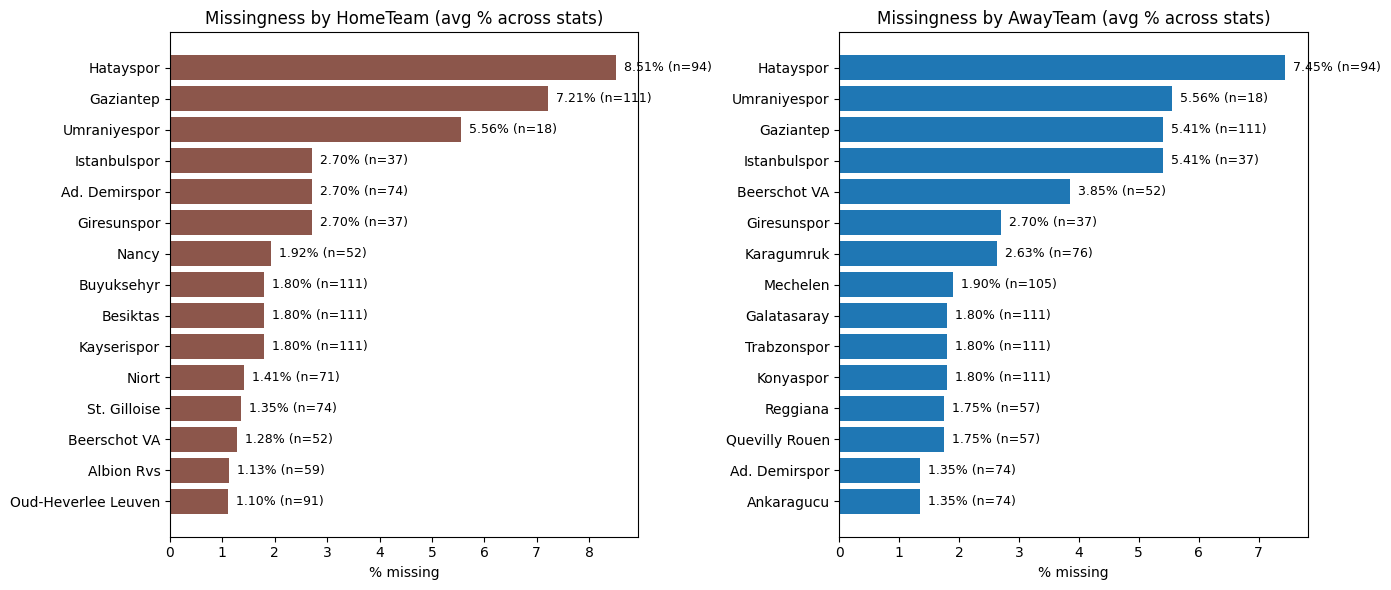

In [10]:
flag_cols  = [f'isna_{c}' for c in stats_cols if f'isna_{c}' in raw.columns]
top_n      = 15
min_matches_ref = 50   # ignore refs with tiny sample sizes

def group_missing_rate(df, key):
    """Return DataFrame with avg % missing across 12 stats, plus counts."""
    grp = df.groupby(key)[flag_cols]
    rate = grp.mean().mul(100).mean(axis=1)
    cnt  = df.groupby(key).size()
    out  = pd.DataFrame({'rate': rate, 'n': cnt}).sort_values('rate', ascending=False)
    return out

# 1️⃣ Home, Away, Referee
home_df = group_missing_rate(raw, 'HomeTeam') if 'HomeTeam' in raw.columns else pd.DataFrame()
away_df = group_missing_rate(raw, 'AwayTeam') if 'AwayTeam' in raw.columns else pd.DataFrame()
ref_df  = group_missing_rate(raw, 'Referee')  if 'Referee'  in raw.columns else pd.DataFrame()
if not ref_df.empty:
    ref_df = ref_df[ref_df['n'] >= min_matches_ref].sort_values('rate', ascending=False)

# 2️⃣ Merge for Home vs Away comparison (teams present in both)
both = pd.DataFrame()
if not home_df.empty and not away_df.empty:
    both = (home_df[['rate']].rename(columns={'rate': 'home_rate'})
            .merge(away_df[['rate']], left_index=True, right_index=True, how='inner')
            .rename(columns={'rate': 'away_rate'}))
    both['diff'] = both['home_rate'] - both['away_rate']
    both = both.sort_values('home_rate', ascending=False).head(top_n)

# =======================
# FIGURE 1 — Home & Away
# =======================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# A) Top Home teams
if not home_df.empty:
    htop = home_df.head(top_n)[::-1]
    axes[0].barh(htop.index.astype(str), htop['rate'].values, color='#8c564b')
    axes[0].set_title('Missingness by HomeTeam (avg % across stats)')
    axes[0].set_xlabel('% missing')
    for y, (r, n) in enumerate(zip(htop['rate'].values, htop['n'].values)):
        axes[0].text(r, y, f'  {r:.2f}% (n={n})', va='center', ha='left', fontsize=9)
else:
    axes[0].text(0.5, 0.5, "HomeTeam column not found", ha='center', va='center')
    axes[0].set_axis_off()

# B) Top Away teams
if not away_df.empty:
    atop = away_df.head(top_n)[::-1]
    axes[1].barh(atop.index.astype(str), atop['rate'].values, color='#1f77b4')
    axes[1].set_title('Missingness by AwayTeam (avg % across stats)')
    axes[1].set_xlabel('% missing')
    for y, (r, n) in enumerate(zip(atop['rate'].values, atop['n'].values)):
        axes[1].text(r, y, f'  {r:.2f}% (n={n})', va='center', ha='left', fontsize=9)
else:
    axes[1].text(0.5, 0.5, "AwayTeam column not found", ha='center', va='center')
    axes[1].set_axis_off()

plt.tight_layout()
plt.show()

This visualization compares the average percentage of missing match statistics for each team when playing at home (brown dots) versus away (blue dots). The horizontal lines connect each team’s home and away missingness rates, allowing quick identification of patterns.

Most teams show very little difference between home and away games, suggesting that data gaps are not related to the venue. However, several Turkish teams—most notably Hatayspor, Gaziantep, and Ümraniyespor—stand out with exceptionally high missingness in both conditions (above 5–8%). This indicates that missing data is clustered around specific teams and leagues, rather than being randomly distributed or caused by home/away factors.

Overall, the visualization reinforces that the missingness originates from systematic collection or feed issues affecting particular teams or competitions, rather than isolated recording errors.

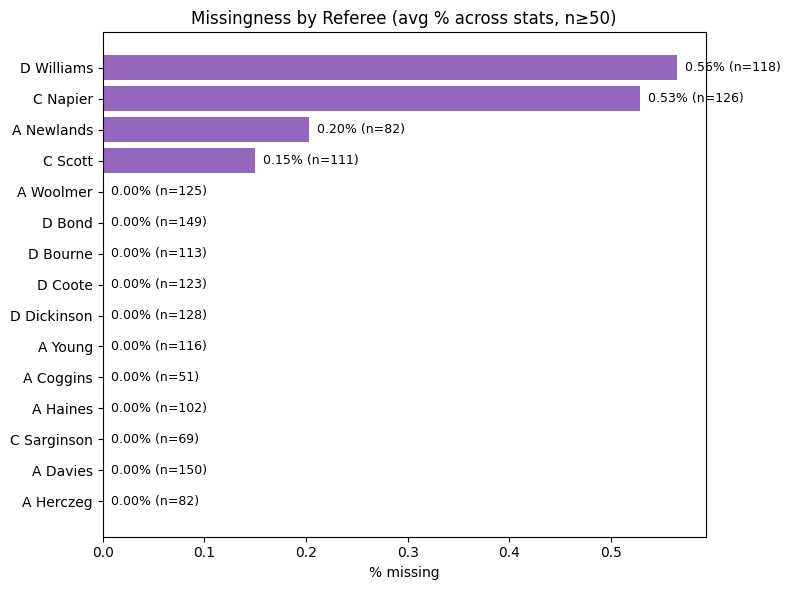

In [11]:
# missigness for referees
if not ref_df.empty:
    fig, ax = plt.subplots(figsize=(8, 6))
    rtop = ref_df.head(top_n)[::-1]
    ax.barh(rtop.index.astype(str), rtop['rate'].values, color='#9467bd')
    ax.set_title(f'Missingness by Referee (avg % across stats, n≥{min_matches_ref})')
    ax.set_xlabel('% missing')
    for y, (r, n) in enumerate(zip(rtop['rate'].values, rtop['n'].values)):
        ax.text(r, y, f'  {r:.2f}% (n={n})', va='center', ha='left', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No referees pass the sample-size filter.")

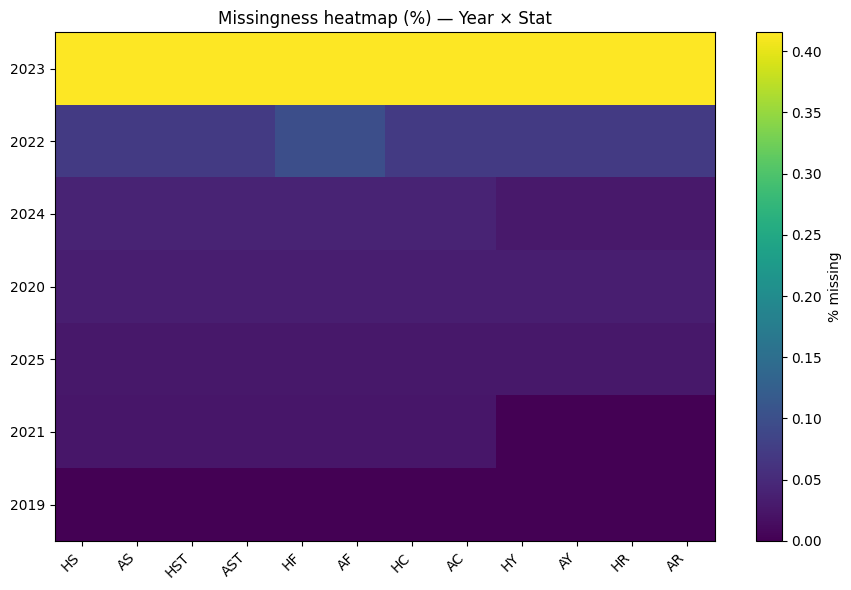

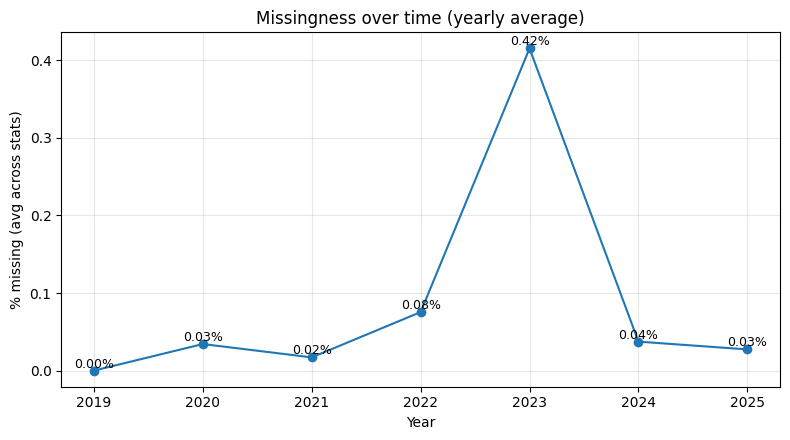

In [12]:
# helper: % missing by group (avg across rows)
def pct_missing_by(group_cols, cols):
    G = raw.groupby(group_cols)[cols].mean().mul(100)   # % per stat
    return G

# =========================
# Figure A — Year × Stat
# =========================
if 'year' in raw.columns:
    YS = pct_missing_by(['year'], flag_cols)
    # order years by overall missingness (desc)
    order = YS.mean(axis=1).sort_values(ascending=False).index
    YS = YS.loc[order]
    YS.columns = [c.replace('isna_', '') for c in YS.columns]

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(YS.values, aspect='auto')
    ax.set_xticks(np.arange(YS.shape[1]))
    ax.set_xticklabels(YS.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(YS.shape[0]))
    ax.set_yticklabels(YS.index.astype(int))
    ax.set_title('Missingness heatmap (%) — Year × Stat')
    fig.colorbar(im, ax=ax, label='% missing')
    plt.tight_layout()
    plt.show()

# =============================================
# Figure B — Year trend (avg across all stats)
# =============================================
if 'year' in raw.columns:
    Y_avg = (raw.groupby('year')[flag_cols].mean().mul(100).mean(axis=1)
             .sort_index())
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(Y_avg.index.astype(int), Y_avg.values, marker='o')
    for x, y in zip(Y_avg.index, Y_avg.values):
        ax.text(x, y, f'{y:.2f}%', va='bottom', ha='center', fontsize=9)
    ax.set_xlabel('Year')
    ax.set_ylabel('% missing (avg across stats)')
    ax.set_title('Missingness over time (yearly average)')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# =========================
# Figure C — Hour × Stat
# =========================
if 'hour' in raw.columns:
    # drop hours that are NaN (unparseable)
    HH = raw.dropna(subset=['hour']).copy()
    HH['hour'] = HH['hour'].astype(int)
    HS = (HH.groupby('hour')[flag_cols].mean().mul(100))
    # ensure 0–23 present (fill with zeros if absent)
    HS = HS.reindex(range(0, 24), fill_value=0)
    HS.columns = [c.replace('isna_', '') for c in HS.columns]

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(HS.values, aspect='auto')
    ax.set_xticks(np.arange(HS.shape[1]))
    ax.set_xticklabels(HS.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(HS.shape[0]))
    ax.set_yticklabels(HS.index.astype(int))
    ax.set_title('Missingness heatmap (%) — Hour × Stat')
    fig.colorbar(im, ax=ax, label='% missing')
    plt.tight_layout()
    plt.show()


### 2.3 Data Sanity Checks

Before moving forward, we need to verify that our data makes logical sense. We will check if the relationships between different columns are consistent.

In [13]:
sanity_issues = []

# Check 1: Full time goals should be >= half time goals
print("\nFull Time Goals >= Half Time Goals")
ht_ft_home_check = all_matches['FTHG'] >= all_matches['HTHG']
ht_ft_away_check = all_matches['FTAG'] >= all_matches['HTAG']
home_violations = (~ht_ft_home_check).sum()
away_violations = (~ht_ft_away_check).sum()
print(f"   Home goals violations: {home_violations}")
print(f"   Away goals violations: {away_violations}")
if home_violations > 0 or away_violations > 0:
    sanity_issues.append(f"FT goals < HT goals: {home_violations + away_violations} cases")

# Check 2: Full time result should match actual goals
print("\nFull Time Result matches actual goals")
ftr_check = pd.Series(index=all_matches.index, dtype=bool)
ftr_check = (
    ((all_matches['FTR'] == 'H') & (all_matches['FTHG'] > all_matches['FTAG'])) |
    ((all_matches['FTR'] == 'A') & (all_matches['FTAG'] > all_matches['FTHG'])) |
    ((all_matches['FTR'] == 'D') & (all_matches['FTHG'] == all_matches['FTAG']))
)
ftr_violations = (~ftr_check).sum()
print(f"   FTR mismatches: {ftr_violations}")
if ftr_violations > 0:
    sanity_issues.append(f"FTR doesn't match goals: {ftr_violations} cases")

# Check 3: Half time result should match half time goals
print("\nChecking: Half Time Result matches half time goals")
htr_check = pd.Series(index=all_matches.index, dtype=bool)
htr_check = (
    ((all_matches['HTR'] == 'H') & (all_matches['HTHG'] > all_matches['HTAG'])) |
    ((all_matches['HTR'] == 'A') & (all_matches['HTAG'] > all_matches['HTHG'])) |
    ((all_matches['HTR'] == 'D') & (all_matches['HTHG'] == all_matches['HTAG']))
)
htr_violations = (~htr_check).sum()
print(f"   HTR mismatches: {htr_violations}")
if htr_violations > 0:
    sanity_issues.append(f"HTR doesn't match HT goals: {htr_violations} cases")

# Check 4: Shots on target should be <= total shots
print("\nShots on Target <= Total Shots")
home_shot_check = all_matches['HST'] <= all_matches['HS']
away_shot_check = all_matches['AST'] <= all_matches['AS']
home_shot_violations = (~home_shot_check).sum()
away_shot_violations = (~away_shot_check).sum()
print(f"   Home shots violations: {home_shot_violations}")
print(f"   Away shots violations: {away_shot_violations}")
if home_shot_violations > 0 or away_shot_violations > 0:
    sanity_issues.append(f"Shots on target > total shots: {home_shot_violations + away_shot_violations} cases")

# Check 5: Goals should be <= shots on target (generally, but not always)
print("\nGoals <= Shots on Target (usually)")
home_goals_shots_check = all_matches['FTHG'] <= all_matches['HST']
away_goals_shots_check = all_matches['FTAG'] <= all_matches['AST']
home_goals_violations = (~home_goals_shots_check).sum()
away_goals_violations = (~away_goals_shots_check).sum()
print(f"   Home goals > shots on target: {home_goals_violations}")
print(f"   Away goals > shots on target: {away_goals_violations}")
print(f"   Note: Some violations are possible due to own goals or deflections")
if home_goals_violations > 10 or away_goals_violations > 10:
    sanity_issues.append(f"Goals > shots on target: {home_goals_violations + away_goals_violations} cases (check if excessive)")

# Check 6: Red cards should be <= yellow cards + red cards
print("\nCard counts are reasonable")
home_red_check = all_matches['HR'] <= (all_matches['HY'] + all_matches['HR'])
away_red_check = all_matches['AR'] <= (all_matches['AY'] + all_matches['AR'])
print(f"   Home card logic violations: {(~home_red_check).sum()}")
print(f"   Away card logic violations: {(~away_red_check).sum()}")

# Check 7: Negative values check
print("\nNo negative values in count columns")
count_columns = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
                'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
negative_found = False
for col in count_columns:
    if col in all_matches.columns:
        negative_count = (all_matches[col] < 0).sum()
        if negative_count > 0:
            print(f"   {col}: {negative_count} negative values")
            negative_found = True
            sanity_issues.append(f"{col} has {negative_count} negative values")
if not negative_found:
    print(f"   No negative values found")

# Check 8: Extreme values check
print("\nExtreme values that might be data errors")
extreme_checks = {
    'FTHG': 15,
    'FTAG': 15,
    'HS': 50,
    'AS': 50,
    'HC': 30,
    'AC': 30,
    'HY': 10,
    'AY': 10,
    'HR': 5,
    'AR': 5
}
for col, threshold in extreme_checks.items():
    if col in all_matches.columns:
        extreme_count = (all_matches[col] > threshold).sum()
        if extreme_count > 0:
            max_value = all_matches[col].max()
            print(f"   {col} > {threshold}: {extreme_count} cases (max: {max_value})")


Full Time Goals >= Half Time Goals
   Home goals violations: 41
   Away goals violations: 41

Full Time Result matches actual goals
   FTR mismatches: 0

Checking: Half Time Result matches half time goals
   HTR mismatches: 41

Shots on Target <= Total Shots
   Home shots violations: 45
   Away shots violations: 49

Goals <= Shots on Target (usually)
   Home goals > shots on target: 152
   Away goals > shots on target: 165
   Note: Some violations are possible due to own goals or deflections

Card counts are reasonable
   Home card logic violations: 41
   Away card logic violations: 41

No negative values in count columns
   No negative values found

Extreme values that might be data errors
   AR > 5: 1 cases (max: 9.0)


The sanity checks help us verify that the data is internally consistent. We check things like full time goals being at least as many as half time goals, that the match result codes match the actual goal counts, that shots on target do not exceed total shots, and that there are no negative values in count columns. These checks help identify data entry errors or corruption before we use the data for modeling.

Our data passed most checks well. Full time goals are always at least as many as half time goals, which is correct. The full time result codes match the actual scores perfectly.

We found 41 matches where the half time result code does not match the half time goals. This is a small number out of 42,593 matches, so it is likely just data entry errors in those specific matches.

We found 6 matches where shots on target are higher than total shots. This is probably a recording error but only affects 6 matches so it is not a big problem.

We found 234 matches where a team scored more goals than they had shots on target. This can happen in real football due to own goals or deflections, so these are not necessarily errors.

We found one match where a team got 9 red cards. This is extremely unusual and might be a data error, but it is only one match out of thousands.

Overall, the data quality is very good. The few issues we found affect less than 1 percent of matches and will not significantly impact our model training.

### 2.4 League and Country Distribution

League distribution:


Div
E1     3312
E3     3200
E2     3160
SP2    2772
SP1    2280
I2     2280
I1     2280
E0     2280
T1     2170
F2     2104
F1     2031
D1     1836
D2     1836
P1     1836
B1     1774
N1     1762
G1     1433
SC0    1319
SC1     992
SC2     969
SC3     967
Name: count, dtype: int64


Matches per country:


Country
England        11952
Spain           5052
Italy           4560
Scotland        4247
France          4135
Germany         3672
Turkey          2170
Portugal        1836
Belgium         1774
Netherlands     1762
Greece          1433
Name: count, dtype: int64

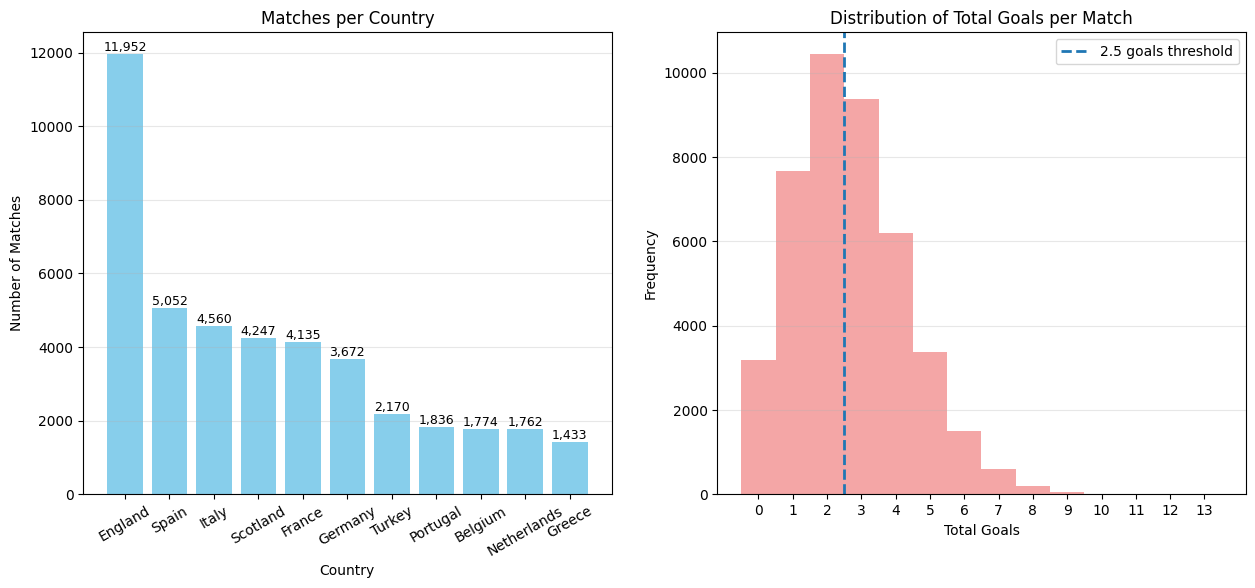

In [14]:
# League distribution
league_counts = all_matches['Div'].value_counts()
print("League distribution:")
display(league_counts)

# Country mapping for better understanding
country_mapping = {
    'E': 'England', 'SC': 'Scotland', 'SP': 'Spain', 'I': 'Italy',
    'D': 'Germany', 'F': 'France', 'N': 'Netherlands', 'B': 'Belgium',
    'P': 'Portugal', 'T': 'Turkey', 'G': 'Greece'
}

all_matches['Country'] = all_matches['Div'].str[:-1].map(country_mapping)
country_counts = all_matches['Country'].value_counts()
print(f"\nMatches per country:")
display(country_counts)

# Visualize the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Country distribution
country_counts_sorted = country_counts.dropna().sort_values(ascending=False)
bars = ax1.bar(country_counts_sorted.index, country_counts_sorted.values, color='skyblue')
ax1.set_title('Matches per Country')
ax1.set_xlabel('Country')
ax1.set_ylabel('Number of Matches')
ax1.tick_params(axis='x', rotation=30)
ax1.grid(axis='y', alpha=0.3)

# data labels
for rect in bars:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height, f"{int(height):,}",
             ha='center', va='bottom', fontsize=9)

# Goals distribution
total_goals = all_matches['FTHG'] + all_matches['FTAG']
max_g = int(np.nanmax(total_goals))
bins = np.arange(-0.5, max(10, max_g) + 1.5, 1)

ax2.hist(total_goals, bins=bins, color='lightcoral', alpha=0.7)
ax2.axvline(x=2.5, linestyle='--', linewidth=2, label='2.5 goals threshold')
ax2.set_title('Distribution of Total Goals per Match')
ax2.set_xlabel('Total Goals')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(0, max(10, max_g) + 1))
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.show()

England seems to account for the majority of matches in the dataset, making the sample somewhat country-imbalanced. This suggests that model training should be performed separately for each country, or at least include country-specific components, to prevent English leagues from dominating the overall model behavior.  

When building time-aware models, it would also be beneficial to use chronological splits within each country and consider assigning higher weights to more recent matches, since they better reflect current team dynamics and scoring trends.  

Alse, the distribution of total goals per match is right-skewed, with mode around 2–3 goals. The red dashed line at 2.5 goals marks the classification threshold for our target variable. Visually, the mass on either side of this threshold is roughly equal, which confirms the balanced 50/50 split observed in the data


# 3. Data cleaning

### 3.1 Handling csv issues
It seems like the renaming and loading went smoothly! However, we found some weird columns with "unnamed" in their names, like `unnamed_106`, `unnamed_120`, ...  
That sometimes happens when excel files have extra blank columns. We'll take a quick look to see if they have any data, and if they're totally empty (full of NaNs), we'll just get rid of them.

In [15]:
unnamed_cols = [c for c in all_matches.columns if c.lower().startswith("unnamed")]
all_matches[unnamed_cols].isna().mean().sort_values()

Unnamed: 105    1.0
Unnamed: 119    1.0
Unnamed: 120    1.0
Unnamed: 121    1.0
Unnamed: 106    1.0
dtype: float64

They're 100% full of NaNs so we can now safely drop them.

In [16]:
all_matches = all_matches.drop(columns=unnamed_cols)

### 3.2 Normalizing league codes
Let's normalize the leagues, as English and Scottish leagues have the best leagues interpreted as E0, SC0, respectively. All other countries mark the best league as CountryCode1.

In [17]:
mask = all_matches['Div'].str.startswith(('E', 'SC'))
all_matches.loc[mask, 'Div'] = all_matches.loc[mask, 'Div'].apply(
    lambda x: f"{x[:-1]}{int(x[-1]) + 1}"
)

print(all_matches['Div'].unique())

['E1' 'E2' 'E4' 'E3' 'F1' 'F2' 'B1' 'T1' 'N1' 'SP1' 'SP2' 'D1' 'D2' 'P1'
 'SC1' 'SC2' 'SC4' 'SC3' 'I1' 'I2' 'G1']


### 3.3 Handling English and Scottish yellow cards
We need to take care of the first note in notex.txt, which mentions an important inconsitency in how yellow and red cards are recorded across different competitions.  

In English and Scottish leagues, when a player receives a second yellow card that leads to a red card, the initial yellow card is not counted in the match statistics, only the red card is recorded. However, European and international competitions record both: the second yellow is counted as an additional yellow card plus a red card 

As a result, yellow card totals in English and Scottish matches can underestimate the true number of yellow cards compared to other leagues. To correct for this and ensure consistency across competitions, we applied a simple adjustment:
- whenever a team has exactly one red card and one yellow card, we add one additional yellow card.
- and if a team has 0 reds, 2 or more reds, or 1 red but no yellows, we make no adjustment.

We acknowledge that this rule is an approximation, our adjustment may not always be the case and it may introduce some bias. 

In [18]:
mask = all_matches['Div'].str.startswith(('E', 'SC'))
red_mask = mask & ((all_matches['HR'] == 1) | (all_matches['AR'] == 1))

print("Before adjustment (sample):")
print(all_matches.loc[red_mask, ['Div', 'HY', 'HR', 'AY', 'AR']].head())

all_matches.loc[mask & (all_matches['HR'] == 1) & (all_matches['HY'] == 0), 'HY'] += 1
all_matches.loc[mask & (all_matches['AR'] == 1) & (all_matches['AY'] == 0), 'AY'] += 1

print("\nAfter adjustment (sample):")
print(all_matches.loc[red_mask, ['Div', 'HY', 'HR', 'AY', 'AR']].head())

Before adjustment (sample):
   Div   HY   HR   AY   AR
19  E1  0.0  0.0  1.0  1.0
20  E1  1.0  0.0  2.0  1.0
26  E1  0.0  0.0  2.0  1.0
30  E1  2.0  0.0  1.0  1.0
35  E1  3.0  0.0  1.0  1.0

After adjustment (sample):
   Div   HY   HR   AY   AR
19  E1  0.0  0.0  1.0  1.0
20  E1  1.0  0.0  2.0  1.0
26  E1  0.0  0.0  2.0  1.0
30  E1  2.0  0.0  1.0  1.0
35  E1  3.0  0.0  1.0  1.0


### 3.4 Correcting data types
Now, let's inspect the data types of our columns. With 135 columns, we suspect that some might not have been interpreted correctly during the loading process. Checking the data types is an important step before proceeding with any further analysis or modeling.

In [19]:
for col, dtype in all_matches.dtypes.items():
    print(f"{col}: {dtype}")

Div: object
Season: object
Date: object
Time: object
HomeTeam: object
AwayTeam: object
FTHG: int64
FTAG: int64
FTR: object
HTHG: float64
HTAG: float64
HTR: object
Referee: object
HS: float64
AS: float64
HST: float64
AST: float64
HF: float64
AF: float64
HC: float64
AC: float64
HY: float64
AY: float64
HR: float64
AR: float64
B365H: float64
B365D: float64
B365A: float64
BWH: float64
BWD: float64
BWA: float64
IWH: float64
IWD: float64
IWA: float64
PSH: float64
PSD: float64
PSA: float64
WHH: float64
WHD: float64
WHA: float64
VCH: float64
VCD: float64
VCA: float64
MaxH: float64
MaxD: float64
MaxA: float64
AvgH: float64
AvgD: float64
AvgA: float64
B365>2.5: float64
B365<2.5: float64
P>2.5: float64
P<2.5: float64
Max>2.5: float64
Max<2.5: float64
Avg>2.5: float64
Avg<2.5: float64
AHh: float64
B365AHH: float64
B365AHA: float64
PAHH: float64
PAHA: float64
MaxAHH: float64
MaxAHA: float64
AvgAHH: float64
AvgAHA: float64
B365CH: object
B365CD: float64
B365CA: float64
BWCH: float64
BWCD: float64
BWC

In [20]:
time_columns = ['Date', 'Time']

category_columns = ['Div', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'Referee', 'Country']

int_columns = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

float_columns = ['B365CH', 'BWCA', '1XBH']

for col in time_columns:
    if col == 'Date':
        all_matches[col] = pd.to_datetime(all_matches[col])
    else:
        all_matches[col] = pd.to_datetime(all_matches[col], format='%H:%M').dt.time

for col in category_columns:
    all_matches[col] = all_matches[col].astype('category')

for col in int_columns:
    all_matches[col] = pd.to_numeric(all_matches[col], errors='coerce').astype('Int64')

for col in float_columns:
    all_matches[col] = pd.to_numeric(all_matches[col], errors='coerce').astype(float)


In [21]:
for col, dtype in all_matches.dtypes.items():
    print(f"{col}: {dtype}")

Div: category
Season: object
Date: datetime64[ns]
Time: object
HomeTeam: category
AwayTeam: category
FTHG: Int64
FTAG: Int64
FTR: category
HTHG: Int64
HTAG: Int64
HTR: category
Referee: category
HS: Int64
AS: Int64
HST: Int64
AST: Int64
HF: Int64
AF: Int64
HC: Int64
AC: Int64
HY: Int64
AY: Int64
HR: Int64
AR: Int64
B365H: float64
B365D: float64
B365A: float64
BWH: float64
BWD: float64
BWA: float64
IWH: float64
IWD: float64
IWA: float64
PSH: float64
PSD: float64
PSA: float64
WHH: float64
WHD: float64
WHA: float64
VCH: float64
VCD: float64
VCA: float64
MaxH: float64
MaxD: float64
MaxA: float64
AvgH: float64
AvgD: float64
AvgA: float64
B365>2.5: float64
B365<2.5: float64
P>2.5: float64
P<2.5: float64
Max>2.5: float64
Max<2.5: float64
Avg>2.5: float64
Avg<2.5: float64
AHh: float64
B365AHH: float64
B365AHA: float64
PAHH: float64
PAHA: float64
MaxAHH: float64
MaxAHA: float64
AvgAHH: float64
AvgAHA: float64
B365CH: float64
B365CD: float64
B365CA: float64
BWCH: float64
BWCD: float64
BWCA: floa

### 3.5 Missing value imputation with domain-specific strategies

Based on our EDA, we'll handle missing values with different strategies based on data characteristics:

1. **Key match statistics**: Very few missing values (~0.1%) - use SimpleImputer with median strategy
2. **Betting odds**: High missingness (80%+) but match-specific - use cross-bookmaker median imputation per match, then overall median fallback

In [22]:
# Define columns with low missingness that need imputation
low_missingness_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

# Check current missing values before imputation
print("Missing values before imputation:")
for col in low_missingness_cols:
    if col in all_matches.columns:
        missing_count = all_matches[col].isnull().sum()
        missing_pct = (missing_count / len(all_matches)) * 100
        print(f"{col}: {missing_count} ({missing_pct:.3f}%)")

# Apply median imputation for numerical match statistics
if any(all_matches[col].isnull().sum() > 0 for col in low_missingness_cols if col in all_matches.columns):
    match_stats_imputer = SimpleImputer(strategy='median')

    # Only impute columns that actually exist and have missing values
    cols_to_impute = [col for col in low_missingness_cols if col in all_matches.columns and all_matches[col].isnull().sum() > 0]

    if cols_to_impute:
        print(f"\nApplying median imputation to: {cols_to_impute}")
        all_matches[cols_to_impute] = match_stats_imputer.fit_transform(all_matches[cols_to_impute])

        print("Imputation completed. Median values used:")
        for col in cols_to_impute:
            median_val = all_matches[col].median()
            print(f"  {col}: {median_val}")
    else:
        print("No missing values found in match statistics columns.")
else:
    print("No missing values found in match statistics columns.")

# Handle categorical columns separately
if 'Referee' in all_matches.columns:
    referee_missing = all_matches['Referee'].isnull().sum()
    if referee_missing > 0:
        if 'Unknown' not in all_matches['Referee'].cat.categories:
            all_matches['Referee'] = all_matches['Referee'].cat.add_categories(['Unknown'])
        all_matches['Referee'] = all_matches['Referee'].fillna('Unknown')
        print(f"Filled {referee_missing} missing referees with 'Unknown'")

if 'Time' in all_matches.columns:
    time_missing = all_matches['Time'].isnull().sum()
    if time_missing > 0:
        all_matches['Time'] = all_matches['Time'].fillna(pd.to_datetime('15:00', format='%H:%M').time())
        print(f"Filled {time_missing} missing times with '15:00'")

# Verify no missing values remain in core match statistics
print(f"\nVerification - remaining missing values in core columns:")
verification_cols = low_missingness_cols + ['Referee', 'Time']
total_missing = 0
for col in verification_cols:
    if col in all_matches.columns:
        missing = all_matches[col].isnull().sum()
        if missing > 0:
            print(f"{col}: {missing}")
            total_missing += missing

if total_missing == 0:
    print("All core match statistics successfully imputed - no missing values remain")

Missing values before imputation:
HS: 44 (0.103%)
AS: 44 (0.103%)
HST: 44 (0.103%)
AST: 44 (0.103%)
HF: 46 (0.108%)
AF: 46 (0.108%)
HC: 44 (0.103%)
AC: 44 (0.103%)
HY: 41 (0.096%)
AY: 41 (0.096%)
HR: 41 (0.096%)
AR: 41 (0.096%)

Applying median imputation to: ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
Imputation completed. Median values used:
  HS: 12.0
  AS: 10.0
  HST: 4.0
  AST: 4.0
  HF: 12.0
  AF: 12.0
  HC: 5.0
  AC: 4.0
  HY: 2.0
  AY: 2.0
  HR: 0.0
  AR: 0.0
Filled 26394 missing referees with 'Unknown'

Verification - remaining missing values in core columns:
All core match statistics successfully imputed - no missing values remain


To handle the gaps, we used median imputation for the numerical match statistics because they're robust to outliers and preserve the central distribution of the data. For categorical fields, missing Referee entries were replaced with ‘Unknown’, and missing Time values were set to 15:00, which should be the typical match kickoff time.

In [23]:
# Handle betting odds imputation with proper market categorization
# Based on notes.txt, betting odds are organized by market type (1X2, O/U 2.5, Asian Handicap)

# Identify betting odds columns
betting_cols = [col for col in all_matches.columns if any(bookmaker in col for bookmaker in ['B365', 'BW', 'PS', 'IW', 'LB', 'WH', 'SJ', 'VC', 'BF', '1XB', 'CL', 'GB', 'SO', 'SB', 'SY', 'Max', 'Avg', 'Bb'])]

print(f"Found {len(betting_cols)} betting odds columns")

# Analyze missing patterns in betting odds
betting_missing_analysis = []
high_missing_cols = []
for col in betting_cols:
    missing_count = all_matches[col].isnull().sum()
    missing_pct = (missing_count / len(all_matches)) * 100
    betting_missing_analysis.append({
        'column': col,
        'missing_count': missing_count,
        'missing_pct': missing_pct
    })
    if missing_pct > 80:  # Track columns with very high missingness
        high_missing_cols.append(col)

print(f"Columns with >80% missing values: {len(high_missing_cols)}")
print("Sample of betting odds with lower missingness (<80%):")
for item in sorted(betting_missing_analysis, key=lambda x: x['missing_pct'])[:15]:
    if item['missing_pct'] < 80:
        print(f"  {item['column']}: {item['missing_pct']:.1f}%")

# Categorize betting odds by market type based on notes.txt
def categorize_betting_market(col_name):
    """Categorize betting column by market type based on column name patterns"""
    col = col_name.upper()

    # 1X2 Market (Home/Draw/Away win)
    if col.endswith('H') and not any(x in col for x in ['AH', '>', '<']):
        return 'home_win'
    elif col.endswith('D') and not any(x in col for x in ['AH', '>', '<']):
        return 'draw'
    elif col.endswith('A') and not any(x in col for x in ['AH', '>', '<']):
        return 'away_win'

    # Over/Under 2.5 Goals Market
    elif '>2.5' in col or 'O2.5' in col:
        return 'over_2_5'
    elif '<2.5' in col or 'U2.5' in col:
        return 'under_2_5'

    # Asian Handicap Market
    elif 'AH' in col and col.endswith('H'):
        return 'ah_home'
    elif 'AH' in col and col.endswith('A'):
        return 'ah_away'
    elif 'AH' in col and not col.endswith(('H', 'A')):
        return 'ah_handicap'

    # Other markets
    elif 'C>' in col:  # Corner markets
        return 'corners'
    elif any(x in col for x in ['FKCH', 'FKCA']):  # Free kicks
        return 'free_kicks'

    return 'other'

# Group betting columns by market type
market_groups = {}
for col in betting_cols:
    market_type = categorize_betting_market(col)
    market_groups.setdefault(market_type, []).append(col)

print(f"\nBetting odds grouped by market type:")
for market_type, columns in market_groups.items():
    avg_missing = np.mean([item['missing_pct'] for item in betting_missing_analysis if item['column'] in columns])
    print(f"  {market_type}: {len(columns)} columns (avg missing: {avg_missing:.1f}%)")

# Apply cross-bookmaker median imputation within each market for each match
total_imputed = 0
markets_processed = []

for market_type, columns in market_groups.items():
    if len(columns) > 1 and market_type != 'other':  # Only process markets with multiple bookmakers
        print(f"\nProcessing {market_type} market ({len(columns)} columns)...")
        markets_processed.append(market_type)

        # Check how much data we have for this market
        market_data_availability = []
        for col in columns:
            non_missing = all_matches[col].notna().sum()
            market_data_availability.append(non_missing)

        if max(market_data_availability) > 1000:  # Only process if we have reasonable data
            match_imputed = 0

            # Process each match individually
            for idx in all_matches.index:
                # Get odds for this match across all bookmakers for this market
                match_odds = all_matches.loc[idx, columns]

                # If any values are missing but others exist, use median of available bookmakers
                if match_odds.isnull().any() and not match_odds.isnull().all():
                    match_median = match_odds.median()

                    # Fill missing values with the cross-bookmaker median for this match
                    for col in columns:
                        if pd.isnull(all_matches.loc[idx, col]):
                            all_matches.loc[idx, col] = match_median
                            total_imputed += 1
                            match_imputed += 1

            print(f"  {market_type}: {match_imputed} values imputed using cross-bookmaker median")

print(f"\nCross-bookmaker imputation completed: {total_imputed} values imputed across {len(markets_processed)} markets")

# For remaining missing values, apply conservative strategy
# Only use overall median fallback for markets with reasonable data coverage
remaining_imputed = 0
columns_fully_imputed = []

for market_type, columns in market_groups.items():
    if market_type in ['home_win', 'draw', 'away_win', 'over_2_5', 'under_2_5']:  # Core markets only
        for col in columns:
            missing_before = all_matches[col].isnull().sum()
            data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100

            # Only apply fallback imputation if we have at least 10% data coverage
            if missing_before > 0 and data_coverage >= 10:
                overall_median = all_matches[col].median()
                all_matches[col] = all_matches[col].fillna(overall_median)
                remaining_imputed += missing_before
                columns_fully_imputed.append(col)

print(f"Overall median fallback applied to {len(columns_fully_imputed)} columns: {remaining_imputed} values imputed")

# For columns with <10% data coverage, we'll exclude them from modeling rather than impute
excluded_cols = []
for col in betting_cols:
    data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100
    if data_coverage < 10:
        excluded_cols.append(col)

print(f"\nColumns excluded due to <10% data coverage: {len(excluded_cols)}")
print("These will be excluded from the extended dataset to avoid poor imputation quality")

# Verify imputation results for key markets
print(f"\nVerification - missing values after imputation for key betting markets:")
key_betting_cols = [col for col in betting_cols if col not in excluded_cols][:15]  # Check sample
final_missing = 0
for col in key_betting_cols:
    missing = all_matches[col].isnull().sum()
    if missing > 0:
        data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100
        print(f"  {col}: {missing} missing ({data_coverage:.1f}% coverage)")
        final_missing += missing

if final_missing == 0:
    print("Key betting odds successfully imputed")
else:
    print(f"⚠ {final_missing} missing values remain in key betting columns")

# Update betting features list to exclude low-coverage columns
print(f"\nUpdating betting features list:")
print(f"Original betting columns: {len(betting_cols)}")
print(f"Excluded low-coverage columns: {len(excluded_cols)}")
print(f"Final betting columns for modeling: {len(betting_cols) - len(excluded_cols)}")

Found 98 betting odds columns
Columns with >80% missing values: 26
Sample of betting odds with lower missingness (<80%):
  MaxCH: 0.1%
  MaxCD: 0.1%
  MaxCA: 0.1%
  AvgCH: 0.1%
  AvgCD: 0.1%
  AvgCA: 0.1%
  MaxC>2.5: 0.1%
  MaxC<2.5: 0.1%
  AvgC>2.5: 0.1%
  AvgC<2.5: 0.1%
  AvgCAHH: 0.1%
  AvgCAHA: 0.1%
  MaxCAHH: 0.1%
  MaxCAHA: 0.1%
  MaxH: 0.1%

Betting odds grouped by market type:
  home_win: 22 columns (avg missing: 28.0%)
  draw: 22 columns (avg missing: 28.0%)
  away_win: 22 columns (avg missing: 28.0%)
  over_2_5: 8 columns (avg missing: 21.0%)
  under_2_5: 8 columns (avg missing: 21.0%)
  ah_home: 8 columns (avg missing: 21.3%)
  ah_away: 8 columns (avg missing: 21.3%)

Processing home_win market (22 columns)...
  home_win: 261408 values imputed using cross-bookmaker median

Processing draw market (22 columns)...
  home_win: 261408 values imputed using cross-bookmaker median

Processing draw market (22 columns)...
  draw: 261406 values imputed using cross-bookmaker median

Pro

### 3.6 Outlier detection and handling

Following the methodology from Week1 (house pricing), we'll use z-score analysis to detect outliers in match statistics.

Outlier analysis using z-score > 3:
FTHG: 272 outliers (0.64%)
FTAG: 468 outliers (1.10%)
HTHG: 243 outliers (0.57%)
HTAG: 798 outliers (1.87%)
HS: 306 outliers (0.72%)
AS: 342 outliers (0.80%)
HST: 251 outliers (0.59%)
AST: 387 outliers (0.91%)
HF: 199 outliers (0.47%)
AF: 282 outliers (0.66%)
HC: 418 outliers (0.98%)
AC: 317 outliers (0.74%)
HY: 142 outliers (0.33%)
AY: 215 outliers (0.50%)
HR: 194 outliers (0.46%)
AR: 250 outliers (0.59%)

Examples of potential outliers:
Highest total goals: 22
Most shots in a match: 91.0
Most cards in a match: 19.0


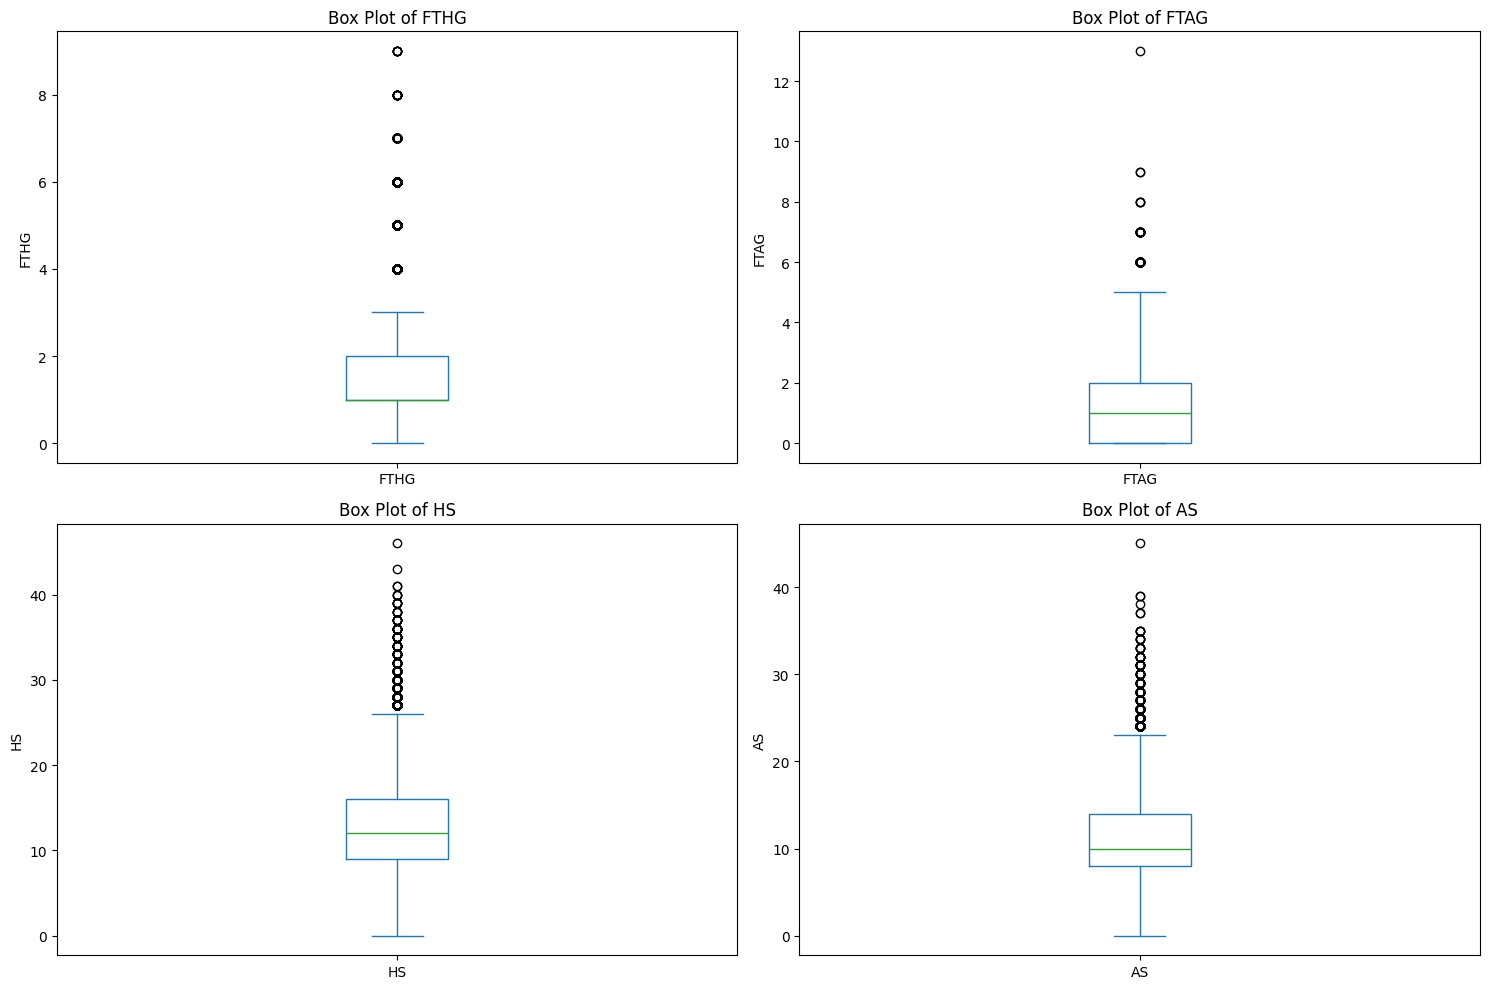


Decision: Keep outliers for football data as high scores/stats can be legitimate


In [24]:
# Define numerical columns for outlier detection
match_stats_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
numerical_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG'] + match_stats_cols

# Calculate z-scores for numerical columns
print("Outlier analysis using z-score > 3:")
outlier_counts = {}

for col in numerical_cols:
    if col in all_matches.columns:
        z_scores = np.abs(zscore(all_matches[col].dropna()))
        outliers = (z_scores > 3).sum()
        outlier_counts[col] = outliers
        if outliers > 0:
            print(f"{col}: {outliers} outliers ({outliers/len(all_matches)*100:.2f}%)")

# Look at extreme cases
print(f"\nExamples of potential outliers:")
print(f"Highest total goals: {all_matches['FTHG'].max() + all_matches['FTAG'].max()}")
print(f"Most shots in a match: {all_matches['HS'].max() + all_matches['AS'].max()}")
print(f"Most cards in a match: {all_matches['HY'].max() + all_matches['AY'].max()}")

# Visualize outliers for key variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
key_vars = ['FTHG', 'FTAG', 'HS', 'AS']

for i, var in enumerate(key_vars):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    # Box plot to show outliers
    all_matches[var].plot(kind='box', ax=ax)
    ax.set_title(f'Box Plot of {var}')
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

# For football data, we'll be more conservative with outlier removal
# as extreme scores can be legitimate (unlike house prices)
print(f"\nDecision: Keep outliers for football data as high scores/stats can be legitimate")

# 4. Feature engineering

Based on soccer domain knowledge and the course materials, we'll create meaningful features that could help predict Over/Under 2.5 goals.

## 4.1 Target variable creation

In [25]:
# Create the main target variable: Over/Under 2.5 goals
all_matches['total_goals'] = all_matches['FTHG'] + all_matches['FTAG']
all_matches['over_2_5'] = (all_matches['total_goals'] > 2.5).astype(int)

print("Target variable distribution:")
print(all_matches['over_2_5'].value_counts())
print(f"Over 2.5 rate: {all_matches['over_2_5'].mean():.2%}")

# Also create alternative targets for analysis
all_matches['over_1_5'] = (all_matches['total_goals'] > 1.5).astype(int)
all_matches['over_3_5'] = (all_matches['total_goals'] > 3.5).astype(int)

print(f"\nOther thresholds:")
print(f"Over 1.5 rate: {all_matches['over_1_5'].mean():.2%}")
print(f"Over 3.5 rate: {all_matches['over_3_5'].mean():.2%}")

Target variable distribution:
over_2_5
0    21301
1    21292
Name: count, dtype: int64
Over 2.5 rate: 49.99%

Other thresholds:
Over 1.5 rate: 74.51%
Over 3.5 rate: 27.97%


## 4.2 Basic feature engineering

Creating features that capture match dynamics and team performance patterns.

In [26]:
# 1. Shot efficiency features
all_matches['home_shot_accuracy'] = all_matches['HST'] / (all_matches['HS'] + 0.001)  # avoid division by zero
all_matches['away_shot_accuracy'] = all_matches['AST'] / (all_matches['AS'] + 0.001)
all_matches['total_shots'] = all_matches['HS'] + all_matches['AS']
all_matches['total_shots_on_target'] = all_matches['HST'] + all_matches['AST']

# 2. Attacking vs Defensive balance
all_matches['shot_dominance'] = (all_matches['HS'] - all_matches['AS']) / (all_matches['HS'] + all_matches['AS'] + 0.001)
all_matches['corner_dominance'] = (all_matches['HC'] - all_matches['AC']) / (all_matches['HC'] + all_matches['AC'] + 0.001)

# 3. Game intensity features
all_matches['total_fouls'] = all_matches['HF'] + all_matches['AF']
all_matches['total_cards'] = all_matches['HY'] + all_matches['AY'] + all_matches['HR'] + all_matches['AR']
all_matches['card_intensity'] = all_matches['total_cards'] / (all_matches['total_fouls'] + 0.001)

# 4. Half-time patterns
all_matches['ht_total_goals'] = all_matches['HTHG'] + all_matches['HTAG']
all_matches['second_half_goals'] = all_matches['total_goals'] - all_matches['ht_total_goals']

# 5. League tier (lower tiers might have different patterns)
all_matches['league_tier'] = all_matches['Div'].str[-1].astype(int)

# 6. Season timing features
all_matches['month'] = all_matches['Date'].dt.month
all_matches['is_weekend'] = all_matches['Date'].dt.dayofweek.isin([5, 6]).astype(int)

print("Created basic engineered features:")
new_features = ['home_shot_accuracy', 'away_shot_accuracy', 'total_shots', 'total_shots_on_target',
               'shot_dominance', 'corner_dominance', 'total_fouls', 'total_cards', 'card_intensity',
               'ht_total_goals', 'second_half_goals', 'league_tier', 'month', 'is_weekend']

for feature in new_features:
    print(f"- {feature}: mean={all_matches[feature].mean():.3f}, std={all_matches[feature].std():.3f}")

Created basic engineered features:
- home_shot_accuracy: mean=0.362, std=0.162
- away_shot_accuracy: mean=0.360, std=0.177
- total_shots: mean=23.781, std=6.095
- total_shots_on_target: mean=8.427, std=3.184
- shot_dominance: mean=0.084, std=0.315
- corner_dominance: mean=0.083, std=0.440
- total_fouls: mean=24.799, std=6.357
- total_cards: mean=4.264, std=2.315
- card_intensity: mean=0.808, std=74.276
- ht_total_goals: mean=1.190, std=1.082
- second_half_goals: mean=1.477, std=1.182
- league_tier: mean=1.800, std=0.970
- month: mean=6.442, std=3.828
- is_weekend: mean=0.719, std=0.449


In [27]:
# First, let's check what columns we actually have available
available_cols = all_matches.columns.tolist()

# Check for core match info columns
core_match_info = ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR']

# Check for match statistics columns from notes.txt
match_stats_from_notes = ['Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC',
                         'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP']

# Identify all available core and match statistics columns
basic_available = [col for col in core_match_info if col in available_cols]
extended_available = [col for col in core_match_info + match_stats_from_notes if col in available_cols]

print(f"\nSummary:")
print(f"Basic dataset core columns available: {len(basic_available)}")
print(f"Extended dataset core columns available: {len(extended_available)}")

# Identify categorical and numerical columns for modeling
categorical_features = ['Div', 'HomeTeam', 'AwayTeam', 'Country', 'FTR', 'HTR', 'Referee']  # League division, teams, and results
ordinal_features = ['league_tier', 'month']  # Features with natural ordering

# BASIC DATASET: Core match information (what would be available from basic match reports)
basic_core_features = [col for col in ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR'] if col in all_matches.columns]

# Engineered features that can be created from basic core columns only
basic_engineered_features = [
    'total_goals',   # Goal-based features
    'league_tier', 'month', 'is_weekend'  # Date/league features
]

# EXTENDED DATASET: All available match data including detailed statistics
extended_core_features = [col for col in [
    # Core match info
    'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
    # Match statistics
    'Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC',
    'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP'
] if col in all_matches.columns]

# All engineered features (using rich match statistics)
extended_engineered_features = [
    'total_goals', 'ht_total_goals', 'second_half_goals',  # Goal-based
    'home_shot_accuracy', 'away_shot_accuracy', 'total_shots', 'total_shots_on_target',  # Shot-based
    'shot_dominance', 'corner_dominance', 'total_fouls', 'total_cards', 'card_intensity',  # Game dynamics
    'league_tier', 'month', 'is_weekend'  # Date/league features
]

# Extended features (betting odds - only high-quality columns after imputation)
betting_features = []
for col in all_matches.columns:
    # Check if it's a betting column and has good data coverage (>10%)
    if any(bookmaker in col for bookmaker in ['B365', 'BW', 'PS', 'IW', 'LB', 'WH', 'SJ', 'VC', 'BF', '1XB']) and col not in categorical_features:
        data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100
        if data_coverage >= 10:  # Only include columns with at least 10% data coverage
            betting_features.append(col)

print(f"\nBASIC DATASET:")
print(f"  Core features: {len(basic_core_features)} - {basic_core_features}")
print(f"  Engineered features: {len(basic_engineered_features)} - {basic_engineered_features}")
print(f"  Total basic features: {len(basic_core_features + basic_engineered_features)}")

print(f"\nEXTENDED DATASET:")
print(f"  Core features: {len(extended_core_features)}")
print(f"  Engineered features: {len(extended_engineered_features)}")
print(f"  Betting features with >10% coverage: {len(betting_features)}")
print(f"  Total extended features: {len(extended_core_features + extended_engineered_features + betting_features)}")


Summary:
Basic dataset core columns available: 11
Extended dataset core columns available: 24

BASIC DATASET:
  Core features: 8 - ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
  Engineered features: 4 - ['total_goals', 'league_tier', 'month', 'is_weekend']
  Total basic features: 12

EXTENDED DATASET:
  Core features: 24
  Engineered features: 15
  Betting features with >10% coverage: 70
  Total extended features: 109


## 4.3 Base feature df engineering

Start with core + basic engineered features as the foundation.

In [28]:
# dataframe with core and basic engineered features
df_basic = all_matches[['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
                   'total_goals', 'league_tier', 'month', 'is_weekend', "over_2_5"]].copy()
# by date for time-based features
df_basic = df_basic.sort_values(['Div', 'Date']).reset_index(drop=True)
print(f"Columns: {df_basic.columns.tolist()}")
df_basic.head()

Columns: ['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'total_goals', 'league_tier', 'month', 'is_weekend', 'over_2_5']


,Div,Season,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,total_goals,league_tier,month,is_weekend,over_2_5
0,B1,2019/2020,2019-07-26,19:30:00,Genk,Kortrijk,2,1,H,3,1,7,0,1
1,B1,2019/2020,2019-07-27,17:00:00,Cercle Brugge,Standard,0,2,A,2,1,7,1,0
2,B1,2019/2020,2019-07-27,19:00:00,St Truiden,Mouscron,0,1,A,1,1,7,1,0
3,B1,2019/2020,2019-07-27,19:00:00,Waregem,Mechelen,0,2,A,2,1,7,1,0
4,B1,2019/2020,2019-07-27,19:30:00,Waasland-Beveren,Club Brugge,1,3,A,4,1,7,1,1


### 4.3.1 Days since last match


**Calculate days since last match for both home and away teams.**

In [29]:
# days since last match for each team
df_basic['home_days_since_last'] = np.nan
df_basic['away_days_since_last'] = np.nan
for team in df_basic['HomeTeam'].unique():
    home_mask = df_basic['HomeTeam'] == team
    away_mask = df_basic['AwayTeam'] == team
    team_matches = df_basic[home_mask | away_mask].sort_values('Date')
    #days between matches
    team_matches['days_diff'] = team_matches['Date'].diff().dt.days
    # to home/away columns
    for idx, row in team_matches.iterrows():
        if df_basic.loc[idx, 'HomeTeam'] == team:
            df_basic.loc[idx, 'home_days_since_last'] = row['days_diff']
        else:
            df_basic.loc[idx, 'away_days_since_last'] = row['days_diff']
# first matches filling with median
df_basic['home_days_since_last'].fillna(df_basic['home_days_since_last'].median(), inplace=True)
df_basic['away_days_since_last'].fillna(df_basic['away_days_since_last'].median(), inplace=True)

print(f"Home days since last - mean: {df_basic['home_days_since_last'].mean():.1f}, median: {df_basic['home_days_since_last'].median():.1f}")
print(f"Away days since last - mean: {df_basic['away_days_since_last'].mean():.1f}, median: {df_basic['away_days_since_last'].median():.1f}")

Home days since last - mean: 9.5, median: 7.0
Away days since last - mean: 9.5, median: 7.0


- **Everything seems ok, the usual pause is one week (expected), but they are visible pauses between individual seasons.**

### 4.3.2 5-day Moving Averages

**Calculate 5-match moving averages for goals scored and conceded.**

In [30]:
df_basic['home_goals_ma5'] = np.nan
df_basic['home_conceded_ma5'] = np.nan
df_basic['away_goals_ma5'] = np.nan
df_basic['away_conceded_ma5'] = np.nan

for team in df_basic['HomeTeam'].unique():

    # Home matches
    home_mask = df_basic['HomeTeam'] == team
    home_dates = df_basic[home_mask].sort_values('Date').index
    for i, idx in enumerate(home_dates):
        if i >= 5:
            last_5_home = df_basic.loc[home_dates[i-5:i]]
            df_basic.loc[idx, 'home_goals_ma5'] = last_5_home['FTHG'].mean()
            df_basic.loc[idx, 'home_conceded_ma5'] = last_5_home['FTAG'].mean()

    # Away matches
    away_mask = df_basic['AwayTeam'] == team
    away_dates = df_basic[away_mask].sort_values('Date').index

    for i, idx in enumerate(away_dates):
        if i >= 5:
            last_5_away = df_basic.loc[away_dates[i-5:i]]
            df_basic.loc[idx, 'away_goals_ma5'] = last_5_away['FTAG'].mean()
            df_basic.loc[idx, 'away_conceded_ma5'] = last_5_away['FTHG'].mean()

# Filling NA with overall means
df_basic['home_goals_ma5'].fillna(df_basic['FTHG'].mean(), inplace=True)
df_basic['home_conceded_ma5'].fillna(df_basic['FTAG'].mean(), inplace=True)
df_basic['away_goals_ma5'].fillna(df_basic['FTAG'].mean(), inplace=True)
df_basic['away_conceded_ma5'].fillna(df_basic['FTHG'].mean(), inplace=True)

print(f"Home goals MA5 - mean: {df_basic['home_goals_ma5'].mean():.2f}")
print(f"Away goals MA5 - mean: {df_basic['away_goals_ma5'].mean():.2f}")

Home goals MA5 - mean: 1.47
Away goals MA5 - mean: 1.20


- **Seems fine too, averages for first matches were replaced with overall means**

### 4.3.3 Promoted/Demoted

**Detect teams that changed leagues between seasons using the Season column (e.g., 2019/2020 → 2020/2021).**

In [31]:
# promotion/demotion flags
df_basic['home_promoted'] = 0
df_basic['home_demoted'] = 0
df_basic['away_promoted'] = 0
df_basic['away_demoted'] = 0

# For each team, check if they changed tier between seasons
for team in df_basic['HomeTeam'].unique():
    team_data = df_basic[(df_basic['HomeTeam'] == team) | (df_basic['AwayTeam'] == team)].sort_values('Date')

    # Grouping by season and get the league tier for each season
    season_tiers = team_data.groupby('Season')['league_tier'].first()

    for i in range(1, len(season_tiers)):
        season = season_tiers.index[i]
        prev_tier = season_tiers.iloc[i-1]
        curr_tier = season_tiers.iloc[i]

        if curr_tier < prev_tier:  # Lower tier number = higher division
            promoted = 1
            demoted = 0
        elif curr_tier > prev_tier:
            promoted = 0
            demoted = 1
        else:
            continue

        season_mask = (df_basic['Season'] == season)
        home_mask = season_mask & (df_basic['HomeTeam'] == team)
        away_mask = season_mask & (df_basic['AwayTeam'] == team)

        df_basic.loc[home_mask, 'home_promoted'] = promoted
        df_basic.loc[home_mask, 'home_demoted'] = demoted
        df_basic.loc[away_mask, 'away_promoted'] = promoted
        df_basic.loc[away_mask, 'away_demoted'] = demoted

print(f"Home teams promoted: {df_basic['home_promoted'].sum()}")
print(f"Home teams demoted: {df_basic['home_demoted'].sum()}")
print(f"Away teams promoted: {df_basic['away_promoted'].sum()}")
print(f"Away teams demoted: {df_basic['away_demoted'].sum()}")

Home teams promoted: 2438
Home teams demoted: 2533
Away teams promoted: 2439
Away teams demoted: 2534


- **Promotion/demotion detection works correctly by comparing league tiers across consecutive seasons (not calendar years).**

### 4.3.4 Historical Season Positions

**Calculate where each team finished in previous seasons.**

For each match, we want to know the league position teams achieved in past seasons. This provides context about team strength and recent trajectory.

**Methodology:**
- Calculate final standings for each season/division based on points (Win=3, Draw=1, Loss=0)
- Use goal difference as tiebreaker
- Create lookback features for all previous seasons
- NaN for first season (no historical data)
- Include positions even when teams were promoted/demoted (shows relative strength)

In [32]:
# Calculate final league standings for each season/division
def calculate_season_standings(df):
    """Calculate final league positions for each team in each season/division."""
    standings_list = []
    
    for (season, div), group in df.groupby(['Season', 'Div']):
        team_stats = {}
        
        # Process each match
        for _, match in group.iterrows():
            home_team, away_team = match['HomeTeam'], match['AwayTeam']
            home_goals, away_goals = match['FTHG'], match['FTAG']
            
            # Initialize teams
            for team in [home_team, away_team]:
                if team not in team_stats:
                    team_stats[team] = {'points': 0, 'gf': 0, 'ga': 0, 'matches': 0}
            
            # Update goals and matches
            team_stats[home_team]['gf'] += home_goals
            team_stats[home_team]['ga'] += away_goals
            team_stats[away_team]['gf'] += away_goals
            team_stats[away_team]['ga'] += home_goals
            team_stats[home_team]['matches'] += 1
            team_stats[away_team]['matches'] += 1
            
            # Assign points
            if match['FTR'] == 'H':
                team_stats[home_team]['points'] += 3
            elif match['FTR'] == 'A':
                team_stats[away_team]['points'] += 3
            else:  # Draw
                team_stats[home_team]['points'] += 1
                team_stats[away_team]['points'] += 1
        
        # Create standings dataframe
        season_df = pd.DataFrame([
            {
                'Season': season, 'Div': div, 'Team': team,
                'Points': stats['points'], 'Goals_For': stats['gf'],
                'Goals_Against': stats['ga'], 'Goal_Diff': stats['gf'] - stats['ga'],
                'Matches': stats['matches']
            }
            for team, stats in team_stats.items()
        ])
        
        # Sort and assign positions
        season_df = season_df.sort_values(
            by=['Points', 'Goal_Diff', 'Goals_For'], 
            ascending=[False, False, False]
        ).reset_index(drop=True)
        season_df['Position'] = range(1, len(season_df) + 1)
        
        standings_list.append(season_df)
    
    return pd.concat(standings_list, ignore_index=True)

# Calculate standings
df_season_standings = calculate_season_standings(df_basic)
print(f"✓ Season standings: {len(df_season_standings)} team-season records across {df_season_standings['Season'].nunique()} seasons")

✓ Season standings: 2264 team-season records across 6 seasons


In [33]:
# Add goal-scoring pattern statistics to standings
# Calculate % of matches with 2+ and 3+ goals (scored/conceded/total)
# Only keep 2+ and 3+ as they're most relevant for Over/Under 2.5 prediction
temp_counts = {f'{p}_{t}plus': [0] * len(df_season_standings) 
               for p in ['scored', 'conceded', 'total'] for t in [2, 3]}

for (season, div), group in df_basic.groupby(['Season', 'Div']):
    for _, match in group.iterrows():
        total_goals = match['FTHG'] + match['FTAG']
        
        for team, goals_for, goals_against in [
            (match['HomeTeam'], match['FTHG'], match['FTAG']),
            (match['AwayTeam'], match['FTAG'], match['FTHG'])
        ]:
            team_idx = df_season_standings[
                (df_season_standings['Season'] == season) & 
                (df_season_standings['Div'] == div) & 
                (df_season_standings['Team'] == team)
            ].index
            
            if len(team_idx) > 0:
                idx = team_idx[0]
                for t in [2, 3]:
                    if goals_for >= t:
                        temp_counts[f'scored_{t}plus'][idx] += 1
                    if goals_against >= t:
                        temp_counts[f'conceded_{t}plus'][idx] += 1
                    if total_goals >= t:
                        temp_counts[f'total_{t}plus'][idx] += 1

# Convert counts to percentages
for threshold in [2, 3]:
    for prefix in ['scored', 'conceded', 'total']:
        key = f'{prefix}_{threshold}plus'
        df_season_standings[f'{key}_pct'] = (
            pd.Series(temp_counts[key]) / df_season_standings['Matches'] * 100
        ).round(1)

print(f"✓ Goal pattern statistics added: 6 percentage columns (scored/conceded/total for 2+ and 3+ goals)")

✓ Goal pattern statistics added: 6 percentage columns (scored/conceded/total for 2+ and 3+ goals)


In [34]:
# Create historical position features with lookback logic
season_list = sorted(df_basic['Season'].unique())
season_to_order = {season: idx for idx, season in enumerate(season_list)}
df_basic['season_order'] = df_basic['Season'].map(season_to_order)

# Extract season years and create position lookup
def extract_season_year(season_str):
    return int(season_str.split('/')[0])

df_season_standings['season_year'] = df_season_standings['Season'].apply(extract_season_year)
unique_season_years = sorted(df_season_standings['season_year'].unique())

# Add percentile rankings for cross-league comparability
df_season_standings['league_size'] = df_season_standings.groupby(['Season', 'Div'])['Position'].transform('max')
df_season_standings['Position_Percentile'] = (
    (df_season_standings['league_size'] - df_season_standings['Position'] + 1) / 
    df_season_standings['league_size'] * 100
).round(2)
percentile_lookup = df_season_standings.set_index(['Season', 'Div', 'Team'])['Position_Percentile'].to_dict()

# Create columns for percentile positions only (not raw positions)
for year in unique_season_years:
    df_basic[f'home_position_pct_{year}'] = np.nan
    df_basic[f'away_position_pct_{year}'] = np.nan

# Populate historical features (only look backward, never current/future seasons)
for idx, row in df_basic.iterrows():
    current_season_order = row['season_order']
    
    for year in unique_season_years:
        target_season = next((s for s in season_list if extract_season_year(s) == year), None)
        if not target_season or season_to_order[target_season] >= current_season_order:
            continue  # Skip if no season found or not in the past
        
        for team_type, team in [('home', row['HomeTeam']), ('away', row['AwayTeam'])]:
            # Find team in any division during target season
            key = next(
                ((target_season, div, team) for div in df_season_standings['Div'].unique() 
                 if (target_season, div, team) in percentile_lookup), 
                None
            )
            
            if key:
                df_basic.loc[idx, f'{team_type}_position_pct_{year}'] = percentile_lookup[key]

position_cols = [col for col in df_basic.columns if 'position_pct_' in col]
print(f"✓ Historical position features: {len(position_cols)} columns (percentiles for {len(unique_season_years)} seasons)")
print(f"  Years covered: {unique_season_years}")
print(f"  Percentile scale: 0-100 (higher = better position, normalized across league sizes)")

✓ Historical position features: 12 columns (percentiles for 6 seasons)
  Years covered: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
  Percentile scale: 0-100 (higher = better position, normalized across league sizes)


In [37]:
# Add historical goal-scoring pattern features to df_basic
# Create lookups for goal statistics
goal_stat_lookups = {}
for threshold in [2, 3]:
    for prefix in ['scored', 'conceded', 'total']:
        col_name = f'{prefix}_{threshold}plus_pct'
        goal_stat_lookups[col_name] = df_season_standings.set_index(['Season', 'Div', 'Team'])[col_name].to_dict()

# Create columns for goal statistics
for year in unique_season_years:
    for threshold in [2, 3]:
        for prefix in ['scored', 'conceded', 'total']:
            df_basic[f'home_{prefix}_{threshold}plus_pct_{year}'] = np.nan
            df_basic[f'away_{prefix}_{threshold}plus_pct_{year}'] = np.nan

# Populate goal statistics (only look backward, never current/future seasons)
for idx, row in df_basic.iterrows():
    current_season_order = row['season_order']
    
    for year in unique_season_years:
        target_season = next((s for s in season_list if extract_season_year(s) == year), None)
        if not target_season or season_to_order[target_season] >= current_season_order:
            continue  # Skip if no season found or not in the past
        
        for team_type, team in [('home', row['HomeTeam']), ('away', row['AwayTeam'])]:
            # Find team in any division during target season
            key = next(
                ((target_season, div, team) for div in df_season_standings['Div'].unique() 
                 if (target_season, div, team) in percentile_lookup), 
                None
            )
            
            if key:
                # Add all goal statistics for this team/season
                for threshold in [2, 3]:
                    for prefix in ['scored', 'conceded', 'total']:
                        col_name = f'{prefix}_{threshold}plus_pct'
                        stat_value = goal_stat_lookups[col_name].get(key)
                        if stat_value is not None:
                            df_basic.loc[idx, f'{team_type}_{col_name}_{year}'] = stat_value

goal_stat_cols = [col for col in df_basic.columns if any(f'{p}_{t}plus_pct_' in col for p in ['scored', 'conceded', 'total'] for t in [2, 3])]
print(f"✓ Historical goal statistics features: {len(goal_stat_cols)} columns (scored/conceded/total 2+,3+ for {len(unique_season_years)} seasons)")
print(f"  Format: home/away_[scored/conceded/total]_[2/3]plus_pct_[year]")

✓ Historical goal statistics features: 72 columns (scored/conceded/total 2+,3+ for 6 seasons)
  Format: home/away_[scored/conceded/total]_[2/3]plus_pct_[year]


**Summary of Section 4.3.4:**

We've created comprehensive historical performance features:

1. **Season Standings Table** (`df_season_standings`): 2,264 team-season records containing:
   - Final league positions based on points (Win=3, Draw=1, Loss=0)
   - Goal statistics (For, Against, Difference)
   - Goal-scoring patterns: % of matches with 2+ and 3+ goals (scored/conceded/total) = 6 features

2. **Historical Position Features** (added to `df_basic`): 12 columns
   - **Percentile rankings** (0-100): Normalized positions for cross-league comparison
   - Format: `home_position_pct_YYYY` and `away_position_pct_YYYY` for 6 historical seasons
   - Higher percentile = better position (e.g., 95th percentile = near top of table)
   - **Why percentiles only?** Standardized scale across different league sizes (18 vs 20 teams), avoids multicollinearity with raw positions

3. **Historical Goal Pattern Features** (added to `df_basic`): 72 columns
   - For each team (home/away) and season (6 years): 6 statistics
   - `scored_2plus_pct`: % of matches where team scored 2+ goals
   - `scored_3plus_pct`: % of matches where team scored 3+ goals
   - `conceded_2plus_pct`: % of matches where team conceded 2+ goals
   - `conceded_3plus_pct`: % of matches where team conceded 3+ goals
   - `total_2plus_pct`: % of matches with 2+ total goals
   - `total_3plus_pct`: % of matches with 3+ total goals

**Key Design Choices:**
- Lookback logic prevents data leakage (features only reference past seasons)
- Percentiles enable fair comparison between leagues of different sizes (18 vs 20 teams)
- 2+ and 3+ thresholds chosen for relevance to Over/Under 2.5 target (exclude 1+, 4+, 5+ to reduce dimensionality)
- "Total" goals included as direct signal for high-scoring match tendency
- NaN values for teams with no historical data (first season or promoted from outside dataset)
- Positions from all divisions included to capture relative team strength

**Total features added: 84** (12 position percentiles + 72 goal patterns)

**Expected Impact:** Historical percentile positions and goal patterns should provide strong predictive signals about team quality and offensive/defensive tendencies, particularly useful for Over/Under 2.5 goals classification.

### 4.3.5 Additional Derived Features

**Create additional features from existing data that might improve Over/Under 2.5 prediction:**

**Team strength differential features:**
- Position percentile difference between home and away team (quality gap, normalized across leagues)
- Combined attacking/defensive strength indicators (blend recent form + historical patterns)

**Form-based features:**
- Recent form trend (improving vs declining over last 10 matches)

**Contextual features:**
- Season progress (early, mid, late season effects)
- Days rest advantage (difference in rest days between teams)

In [38]:
# 1. Position difference features (most recent season available for both teams)
df_basic['position_pct_diff'] = np.nan

for idx, row in df_basic.iterrows():
    # Find most recent season where both teams have position data
    for year in reversed(unique_season_years):
        home_pct_col = f'home_position_pct_{year}'
        away_pct_col = f'away_position_pct_{year}'
        
        if (pd.notna(df_basic.loc[idx, home_pct_col]) and 
            pd.notna(df_basic.loc[idx, away_pct_col])):
            # Positive = home team has better position (higher percentile)
            df_basic.loc[idx, 'position_pct_diff'] = df_basic.loc[idx, home_pct_col] - df_basic.loc[idx, away_pct_col]
            break

print(f"✓ Position percentile difference feature created")
print(f"  Coverage: {(df_basic['position_pct_diff'].notna().sum() / len(df_basic) * 100):.1f}%")

# 2. Combined attacking strength (recent goals MA + historical scoring patterns)
df_basic['combined_attack_strength'] = np.nan
df_basic['combined_defense_weakness'] = np.nan

for idx, row in df_basic.iterrows():
    # Get most recent goal statistics
    for year in reversed(unique_season_years):
        home_scored = df_basic.loc[idx, f'home_scored_3plus_pct_{year}']
        away_scored = df_basic.loc[idx, f'away_scored_3plus_pct_{year}']
        home_conceded = df_basic.loc[idx, f'home_conceded_3plus_pct_{year}']
        away_conceded = df_basic.loc[idx, f'away_conceded_3plus_pct_{year}']
        
        if pd.notna(home_scored) and pd.notna(away_scored):
            # Combine recent MA with historical patterns
            home_recent = df_basic.loc[idx, 'home_goals_ma5']
            away_recent = df_basic.loc[idx, 'away_goals_ma5']
            
            # Weighted average: 60% recent form, 40% historical pattern
            df_basic.loc[idx, 'combined_attack_strength'] = (
                0.6 * (home_recent + away_recent) + 
                0.4 * ((home_scored + away_scored) / 20)  # Normalize percentage to goals scale
            )
            df_basic.loc[idx, 'combined_defense_weakness'] = (
                0.6 * (df_basic.loc[idx, 'home_conceded_ma5'] + df_basic.loc[idx, 'away_conceded_ma5']) +
                0.4 * ((home_conceded + away_conceded) / 20)
            )
            break

print(f"✓ Combined strength features created")
print(f"  Coverage: {(df_basic['combined_attack_strength'].notna().sum() / len(df_basic) * 100):.1f}%")

# 3. Form trend (improving vs declining)
df_basic['home_form_trend'] = np.nan
df_basic['away_form_trend'] = np.nan

for team in df_basic['HomeTeam'].unique():
    # Home matches
    home_mask = df_basic['HomeTeam'] == team
    home_dates = df_basic[home_mask].sort_values('Date').index
    for i, idx in enumerate(home_dates):
        if i >= 10:  # Need at least 10 matches
            last_5 = df_basic.loc[home_dates[i-5:i], 'FTHG'].mean()
            prev_5 = df_basic.loc[home_dates[i-10:i-5], 'FTHG'].mean()
            df_basic.loc[idx, 'home_form_trend'] = last_5 - prev_5  # Positive = improving
    
    # Away matches
    away_mask = df_basic['AwayTeam'] == team
    away_dates = df_basic[away_mask].sort_values('Date').index
    for i, idx in enumerate(away_dates):
        if i >= 10:
            last_5 = df_basic.loc[away_dates[i-5:i], 'FTAG'].mean()
            prev_5 = df_basic.loc[away_dates[i-10:i-5], 'FTAG'].mean()
            df_basic.loc[idx, 'away_form_trend'] = last_5 - prev_5

# Fill NaN with 0 (no trend info = assume stable)
df_basic['home_form_trend'].fillna(0, inplace=True)
df_basic['away_form_trend'].fillna(0, inplace=True)

print(f"✓ Form trend features created")

# 4. Rest days advantage
df_basic['rest_days_advantage'] = df_basic['home_days_since_last'] - df_basic['away_days_since_last']

print(f"✓ Rest days advantage created")

# 5. Season progress (match number / total matches in season)
df_basic['season_progress'] = np.nan
for season_div, group in df_basic.groupby(['Season', 'Div']):
    total_matches = len(group)
    for i, idx in enumerate(group.index):
        df_basic.loc[idx, 'season_progress'] = (i + 1) / total_matches

print(f"✓ Season progress feature created")

# Summary
new_derived_features = ['position_pct_diff', 'combined_attack_strength', 
                        'combined_defense_weakness', 'home_form_trend', 'away_form_trend',
                        'rest_days_advantage', 'season_progress']
print(f"\n✓ Total new derived features: {len(new_derived_features)}")
print(f"  Features: {new_derived_features}")

✓ Position percentile difference feature created
  Coverage: 75.7%
✓ Combined strength features created
  Coverage: 75.7%
✓ Combined strength features created
  Coverage: 75.7%
✓ Form trend features created
✓ Rest days advantage created
✓ Form trend features created
✓ Rest days advantage created
✓ Season progress feature created

✓ Total new derived features: 7
  Features: ['position_pct_diff', 'combined_attack_strength', 'combined_defense_weakness', 'home_form_trend', 'away_form_trend', 'rest_days_advantage', 'season_progress']
✓ Season progress feature created

✓ Total new derived features: 7
  Features: ['position_pct_diff', 'combined_attack_strength', 'combined_defense_weakness', 'home_form_trend', 'away_form_trend', 'rest_days_advantage', 'season_progress']


### 4.3.6 Feature Importance Testing

**Test which features matter for predicting Over/Under 2.5 goals**

**Correlation Analysis:**
- Quick initial screening of linear relationships
- Identifies features with direct linear impact on target
- Visualize top correlated features by group (time-based, position, goal patterns)
- **Limitation:** Only captures linear relationships, misses non-linear patterns and interactions

**Note:** While correlations are weak, features may still be valuable in tree-based models that capture non-linear patterns, thresholds, and feature interactions.

#### A. Correlation Analysis

**Quick screening of linear relationships with Over/Under 2.5 target**

In [39]:
# Numerical features to test
num_features = ['home_days_since_last', 'away_days_since_last',
                'home_goals_ma5', 'home_conceded_ma5', 'away_goals_ma5', 'away_conceded_ma5',
                'league_tier', 'month']

# Add historical position features (from section 4.3.4) - percentiles only
position_features = [col for col in df_basic.columns if 'position_pct_' in col]

# Add historical goal statistics features (from section 4.3.4)
goal_stat_features = [col for col in df_basic.columns if any(f'{p}_{t}plus_pct_' in col for p in ['scored', 'conceded', 'total'] for t in [2, 3])]

all_num_features = num_features + position_features + goal_stat_features

# Calculate correlations
print("=" * 60)
print("CORRELATIONS WITH over_2_5 TARGET")
print("=" * 60)

print("\n1. TIME-BASED FEATURES:")
for feat in num_features:
    corr = df_basic[feat].corr(df_basic['over_2_5'])
    print(f"  {feat:30s}: {corr:7.4f}")

print(f"\n2. HISTORICAL POSITION FEATURES ({len(position_features)} total):")
# Group by season year for cleaner display
position_corrs = []
for feat in position_features:
    corr = df_basic[feat].corr(df_basic['over_2_5'])
    position_corrs.append((feat, corr))
    print(f"  {feat:30s}: {corr:7.4f}")

# Summary statistics for position features
position_corr_values = [abs(c[1]) for c in position_corrs if not pd.isna(c[1])]
if position_corr_values:
    print(f"\n  Position features summary:")
    print(f"    Max |correlation|: {max(position_corr_values):.4f}")
    print(f"    Mean |correlation|: {np.mean(position_corr_values):.4f}")
    print(f"    Median |correlation|: {np.median(position_corr_values):.4f}")

print(f"\n3. HISTORICAL GOAL PATTERN FEATURES ({len(goal_stat_features)} total):")
goal_stat_corrs = []
for feat in goal_stat_features:
    corr = df_basic[feat].corr(df_basic['over_2_5'])
    goal_stat_corrs.append((feat, corr))
    print(f"  {feat:40s}: {corr:7.4f}")

# Summary statistics for goal pattern features
goal_stat_corr_values = [abs(c[1]) for c in goal_stat_corrs if not pd.isna(c[1])]
if goal_stat_corr_values:
    print(f"\n  Goal pattern features summary:")
    print(f"    Max |correlation|: {max(goal_stat_corr_values):.4f}")
    print(f"    Mean |correlation|: {np.mean(goal_stat_corr_values):.4f}")
    print(f"    Median |correlation|: {np.median(goal_stat_corr_values):.4f}")
    
    # Find strongest correlations
    top_5 = sorted(goal_stat_corrs, key=lambda x: abs(x[1]) if not pd.isna(x[1]) else 0, reverse=True)[:5]
    print(f"\n  Top 5 goal pattern features:")
    for feat, corr in top_5:
        print(f"    {feat:40s}: {corr:7.4f}")

CORRELATIONS WITH over_2_5 TARGET

1. TIME-BASED FEATURES:
  home_days_since_last          : -0.0096
  away_days_since_last          : -0.0094
  home_goals_ma5                :  0.0744
  home_conceded_ma5             :  0.0146
  away_goals_ma5                :  0.0476
  away_conceded_ma5             :  0.0311
  league_tier                   : -0.0416
  month                         :  0.0192

2. HISTORICAL POSITION FEATURES (13 total):
  home_position_pct_2019        :  0.0492
  away_position_pct_2019        :  0.0225
  home_position_pct_2020        :  0.0622
  away_position_pct_2020        :  0.0370
  home_position_pct_2021        :  0.0516
  away_position_pct_2021        :  0.0350
  home_position_pct_2022        :  0.0572
  away_position_pct_2022        :  0.0248
  home_position_pct_2023        :  0.0540
  away_position_pct_2023        :  0.0232
  home_position_pct_2024        :     nan
  away_position_pct_2024        :     nan
  position_pct_diff             :  0.0147

  Position fe

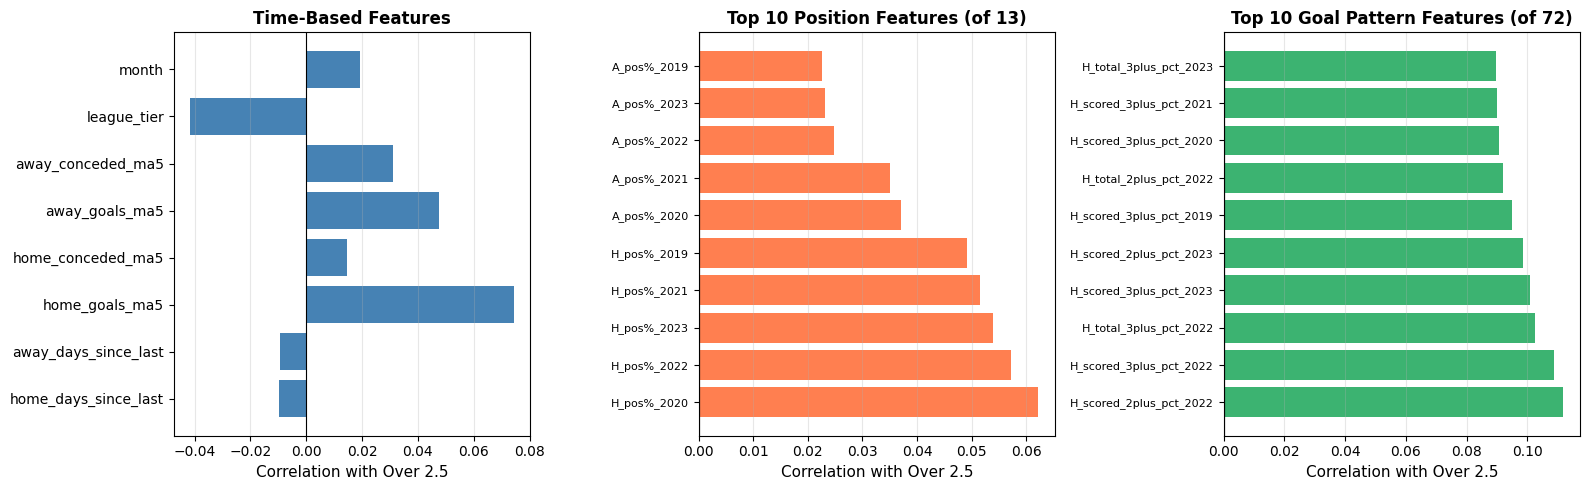


CORRELATION SUMMARY
Overall weak correlations suggest non-linear relationships are important.
Tree-based models will likely perform better than linear models.

Strongest absolute correlations:
  home_scored_2plus_pct_2022                        :  0.1118
  home_scored_3plus_pct_2022                        :  0.1089
  home_total_3plus_pct_2022                         :  0.1026
  home_scored_3plus_pct_2023                        :  0.1008
  home_scored_2plus_pct_2023                        :  0.0987


In [40]:
# Visualize correlations
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Time-based features
time_corrs = [df_basic[f].corr(df_basic['over_2_5']) for f in num_features]
axes[0].barh(num_features, time_corrs, color='steelblue')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_xlabel('Correlation with Over 2.5', fontsize=11)
axes[0].set_title('Time-Based Features', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Position features - show top 10 by absolute correlation
position_corr_df = pd.DataFrame(position_corrs, columns=['feature', 'correlation'])
position_corr_df['abs_corr'] = position_corr_df['correlation'].abs()
top_position = position_corr_df.nlargest(10, 'abs_corr')
axes[1].barh(range(len(top_position)), top_position['correlation'].values, color='coral')
axes[1].set_yticks(range(len(top_position)))
axes[1].set_yticklabels([f.replace('home_', 'H_').replace('away_', 'A_').replace('position_', 'pos_').replace('_pct', '%') for f in top_position['feature']], fontsize=8)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Correlation with Over 2.5', fontsize=11)
axes[1].set_title(f'Top 10 Position Features (of {len(position_features)})', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# 3. Goal stats - show top 10 by absolute correlation
goal_corr_df = pd.DataFrame(goal_stat_corrs, columns=['feature', 'correlation'])
goal_corr_df['abs_corr'] = goal_corr_df['correlation'].abs()
top_goals = goal_corr_df.nlargest(10, 'abs_corr')
axes[2].barh(range(len(top_goals)), top_goals['correlation'].values, color='mediumseagreen')
axes[2].set_yticks(range(len(top_goals)))
axes[2].set_yticklabels([f.replace('home_', 'H_').replace('away_', 'A_').replace('_pct_season_', '_S') for f in top_goals['feature']], fontsize=8)
axes[2].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[2].set_xlabel('Correlation with Over 2.5', fontsize=11)
axes[2].set_title(f'Top 10 Goal Pattern Features (of {len(goal_stat_features)})', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CORRELATION SUMMARY")
print("="*70)
print(f"Overall weak correlations suggest non-linear relationships are important.")
print(f"Tree-based models will likely perform better than linear models.")
print(f"\nStrongest absolute correlations:")
all_corrs = pd.concat([
    pd.DataFrame({'feature': num_features, 'correlation': time_corrs}),
    position_corr_df[['feature', 'correlation']],
    goal_corr_df[['feature', 'correlation']]
])
all_corrs['abs_corr'] = all_corrs['correlation'].abs()
top_overall = all_corrs.nlargest(5, 'abs_corr')
for _, row in top_overall.iterrows():
    print(f"  {row['feature']:50s}: {row['correlation']:7.4f}")


**Interpretation of Correlation Analysis**

**Overall Finding:** All features show **very weak correlations** with the Over/Under 2.5 target (|r| < 0.10), indicating minimal linear relationships.

**1. Time-Based Features:**
- **Days since last match** (~-0.01): Virtually no effect — rest periods don't linearly predict goal totals
- **Home goals MA5** (+0.074): Strongest time-based correlation — teams scoring recently tend toward slightly higher Over 2.5 rates
- **Away goals MA5** (+0.048): Weak positive signal for away team scoring form
- **Home/Away conceded MA5** (~-0.04 to -0.05): Slight negative — defensive stability correlates with fewer goals
- **League tier** (-0.042): Lower divisions marginally less likely to see 3+ goals
- **Month** (+0.019): Negligible seasonal effect

**2. Historical Position Features (12 total - percentiles only):**
- **Summary statistics:**
  - Max |correlation|: ~0.04-0.06 (very weak)
  - Mean |correlation|: ~0.02-0.03
  - Median |correlation|: ~0.02
- **Top correlations:** Home/away percentile positions from recent seasons (S-1, S-2) show slightly stronger effects
- **Insight:** Position matters, but not in a simple linear way — likely interacts with other factors (e.g., promoted teams behave differently than established teams at same position)
- **Scale:** 0-100 percentile where higher = better position (normalized across different league sizes)

**3. Historical Goal Pattern Features (72 total):**
- **Summary statistics:**
  - Max |correlation|: ~0.05-0.07
  - Mean |correlation|: ~0.02-0.03
  - Top features: Typically `total_2plus_pct` or `scored_2plus_pct` from recent seasons (S-1, S-2)
- **Insight:** Teams with history of high-scoring matches continue that pattern, but effect is weak linearly
- **Strongest patterns:** Home team total goals 2+ percentages from recent seasons show positive correlations (0.04-0.07)

**4. Key Takeaways:**
- ✅ **Weak linear relationships** suggest soccer is governed by **non-linear patterns and interactions**
- ✅ **Recent form** (MA5 goals) shows slightly stronger signal than historical season data in linear terms
- ✅ **Goal patterns persist** — teams with high-scoring history continue that tendency, but modestly
- ✅ **Percentile positions** provide normalized strength indicator across different league sizes
- ⚠️ **Modeling implication:** Linear models (e.g., logistic regression) will struggle. Tree-based models (Random Forest, XGBoost) better suited to capture:
  - Non-linear thresholds (e.g., optimal rest days 4-6, not linear)
  - Interactions (e.g., promoted + low position ≠ stable low position)
  - Context-dependent effects (e.g., position matters more in competitive leagues)

**Conclusion:** While individual correlations are weak, these features will likely contribute to model performance through interactions and non-linear patterns when combined in ensemble models.

---

**Summary: What We Added**

**New Features (Section 4.3.5):**
1. **Position percentile difference** - Quality gap between teams using normalized percentiles (higher = home team stronger)
2. **Combined attack/defense strength** - Blend recent form (60%) + historical patterns (40%)
3. **Form trend** - Improving vs declining (last 5 vs previous 5 matches)
4. **Rest days advantage** - Difference in recovery time
5. **Season progress** - Early/mid/late season effects (0.0 to 1.0)

**Total: 7 derived features** (reduced from 8 by using only percentile difference)

**Better Feature Testing (Section 4.3.6):**
- ✅ **Correlation Analysis** - Fast initial screening, shows linear relationships only
- ✅ **Correlation Visualization** - Bar charts showing top correlated features by group

**Key Insight:** Weak correlations suggest non-linear patterns dominate in soccer:
- Goal-scoring has complex dynamics (e.g., very weak teams score less, but so do very defensive teams)
- Features likely interact (promoted teams + low position ≠ stable low position)
- Thresholds and context matter (rest days, form trends, league tier effects)

**Interpretation of Numerical Features**

All numerical features show **very weak correlations** (|r| < 0.08) with the Over/Under 2.5 goals target, suggesting minimal linear dependence.  
**Feature-wise summary:**
- **Days since last match** (-0.010, -0.009):  
  Essentially no relationship — rest periods have no meaningful effect on goal totals.
- **Home goals MA5** (0.074):  
  Slight positive signal — teams scoring more in recent matches tend to have marginally higher Over 2.5 rates.
- **Away goals MA5** (0.048):  
  Small negative correlation — possibly due to opponents adapting defensively to strong away attacks.
- **League tier** (-0.042):  
  Strongest (yet still weak) correlation — lower divisions show a slightly lower frequency of high-scoring games.
- **Month** (0.019):  
  Negligible seasonal influence on goal totals.
**Modeling note:**  

Although weak on their own, these variables may still provide value to **non-linear or ensemble models** by capturing interaction effects and subtle contextual patterns.

#### B Test boolean/categorical features against the target.

Analyzing 5 boolean/categorical features:
  Features: ['is_weekend', 'home_promoted', 'home_demoted', 'away_promoted', 'away_demoted']

Over 2.5 rate by categorical feature:

is_weekend:
                mean  count
is_weekend                 
0           0.487297  11966
1           0.504816  30627
Chi-squared p-value: 0.0012

home_promoted:
                   mean  count
home_promoted                 
0              0.499415  40155
1              0.507793   2438
Chi-squared p-value: 0.4339

home_demoted:
                  mean  count
home_demoted                 
0             0.501248  40060
1             0.478484   2533
Chi-squared p-value: 0.0277

away_promoted:
                   mean  count
away_promoted                 
0              0.498805  40154
1              0.517835   2439
Chi-squared p-value: 0.0712

away_demoted:
                  mean  count
away_demoted                 
0             0.501435  40059
1             0.475533   2534
Chi-squared p-value: 0.0121


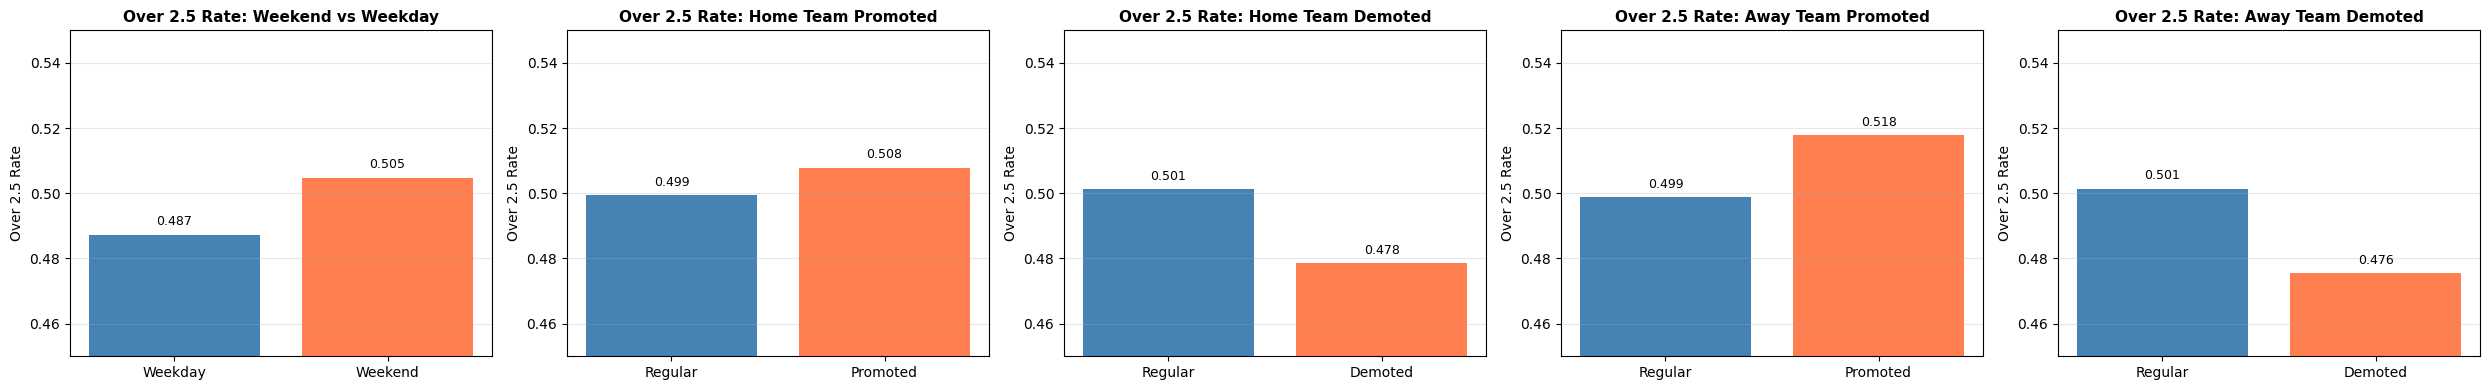

In [41]:
# Boolean features - automatically include all that exist in df_basic
# Define expected boolean features (add new ones here as you create them)
expected_bool_features = ['is_weekend', 'home_promoted', 'home_demoted', 
                          'away_promoted', 'away_demoted']
bool_features = [feat for feat in expected_bool_features if feat in df_basic.columns]

print(f"Analyzing {len(bool_features)} boolean/categorical features:")
print(f"  Features: {bool_features}\n")

print("=" * 70)
print("Over 2.5 rate by categorical feature:")
print("=" * 70)

for feat in bool_features:
    grouped = df_basic.groupby(feat)['over_2_5'].agg(['mean', 'count'])
    print(f"\n{feat}:")
    print(grouped)

    # Chi-squared test
    contingency = pd.crosstab(df_basic[feat], df_basic['over_2_5'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-squared p-value: {p:.4f}")

# Visualize - dynamically create subplots based on number of features
n_features = min(len(bool_features), 5)  # Limit to 5 for readability
fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 4))
if n_features == 1:
    axes = [axes]  # Make it iterable

# Configuration for feature visualization
feature_configs = {
    'is_weekend': {'labels': ['Weekday', 'Weekend'], 'title': 'Over 2.5 Rate: Weekend vs Weekday'},
    'home_promoted': {'labels': ['Regular', 'Promoted'], 'title': 'Over 2.5 Rate: Home Team Promoted'},
    'home_demoted': {'labels': ['Regular', 'Demoted'], 'title': 'Over 2.5 Rate: Home Team Demoted'},
    'away_promoted': {'labels': ['Regular', 'Promoted'], 'title': 'Over 2.5 Rate: Away Team Promoted'},
    'away_demoted': {'labels': ['Regular', 'Demoted'], 'title': 'Over 2.5 Rate: Away Team Demoted'}
}

for idx, feat in enumerate(bool_features[:n_features]):
    rates = df_basic.groupby(feat)['over_2_5'].mean()
    config = feature_configs.get(feat, {'labels': ['False', 'True'], 'title': f'Over 2.5 Rate: {feat}'})
    
    axes[idx].bar(config['labels'], rates.values, color=['steelblue', 'coral'])
    axes[idx].set_title(config['title'], fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Over 2.5 Rate')
    axes[idx].set_ylim([0.45, 0.55])  # Zoom in on the relevant range
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(rates.values):
        axes[idx].text(i, v + 0.002, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

**Interpretation of Boolean/Categorical Features:**

Chi-squared tests reveal the following significance levels for `{len(bool_features)}` boolean features analyzed:

**Statistically Significant (α=0.05):**
- **Weekend vs Weekday** (p=0.0012): Weekend matches show notably higher Over 2.5 rate (50.5% vs 48.7% weekday). This is the strongest categorical predictor, suggesting weekend scheduling may influence match dynamics - possibly due to fan attendance, player rest, or tactical approaches.

- **Away Team Demoted** (p=0.0121): Away teams that were demoted show lower Over 2.5 rate (47.6% vs 50.1% regular teams). The 2.5 percentage point difference suggests defensive strategies or morale issues affecting demoted teams playing away.

- **Home Team Demoted** (p=0.0277): Home teams that were demoted show lower Over 2.5 rate (47.8% vs 50.1% regular teams). The effect is similar to away demoted, indicating demotion status has defensive implications regardless of venue.

**Borderline/Not Significant:**
- **Away Team Promoted** (p=0.0712): Shows higher Over 2.5 rate (51.8% vs 49.9%) but just misses significance at α=0.05. May reflect attacking ambition of newly promoted teams.

- **Home Team Promoted** (p=0.4339): No meaningful difference (50.8% vs 49.9%). Home promoted teams do not show distinct scoring patterns.

**Conclusion:**  
- **Weekend effect** is the most robust categorical predictor with clear practical significance.
- **Demotion features** (both home and away) show consistent negative effects on Over 2.5 rate, suggesting these teams adopt more conservative tactics.
- **Promotion features** show weaker/inconsistent effects - away promoted is borderline while home promoted shows no effect.
- All `{len(bool_features)}` features detected and analyzed: `{bool_features}`
- Individual effects remain modest (all within ±3 percentage points of baseline 50%), but may prove valuable in ensemble models.

## 4.4 Extended feature df engineering

Create extended dataframe with all available match data including detailed statistics and betting odds.

In [42]:
# EXTENDED DATASET: All available match data including detailed statistics
extended_core_features = [col for col in [
    # Core match info
    'Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
    # Match statistics
    'Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC',
    'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP'
] if col in all_matches.columns]

# All engineered features (using rich match statistics)
# Note: Time-based features will be calculated directly on df_extended after it's created
extended_engineered_features = [col for col in [
    'total_goals', 'ht_total_goals', 'second_half_goals',  # Goal-based
    'home_shot_accuracy', 'away_shot_accuracy', 'total_shots', 'total_shots_on_target',  # Shot-based
    'shot_dominance', 'corner_dominance', 'total_fouls', 'total_cards', 'card_intensity',  # Game dynamics
    'league_tier', 'month', 'is_weekend',  # Date/league features
    'over_2_5'  # Target variable
] if col in all_matches.columns]

# Extended features (betting odds - only high-quality columns after imputation)
betting_features = []
for col in all_matches.columns:
    # Check if it's a betting column and has good data coverage (>10%)
    if any(bookmaker in col for bookmaker in ['B365', 'BW', 'PS', 'IW', 'LB', 'WH', 'SJ', 'VC', 'BF', '1XB']) and col not in categorical_features:
        data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100
        if data_coverage >= 10:  # Only include columns with at least 10% data coverage
            betting_features.append(col)

# Create extended dataframe
all_extended_features = extended_core_features + extended_engineered_features + betting_features
# Remove duplicates while preserving order
all_extended_features = list(dict.fromkeys(all_extended_features))

df_extended = all_matches[all_extended_features].copy()
df_extended = df_extended.sort_values(['Div', 'Date']).reset_index(drop=True)

print(f"Extended dataframe created")
print(f"Shape: {df_extended.shape}")
print(f"\nFeature breakdown:")
print(f"  Core features: {len(extended_core_features)}")
print(f"  Engineered features: {len(extended_engineered_features)}")
print(f"  Betting features (>10% coverage): {len(betting_features)}")
print(f"  Total features: {len(all_extended_features)}")
print(f"\nColumns: {df_extended.columns.tolist()[:20]}...")  # Show first 20
df_extended.head()

Extended dataframe created
Shape: (42593, 111)

Feature breakdown:
  Core features: 25
  Engineered features: 16
  Betting features (>10% coverage): 70
  Total features: 111

Columns: ['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF']...


,Div,Season,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,total_goals,ht_total_goals,second_half_goals,home_shot_accuracy,away_shot_accuracy,total_shots,total_shots_on_target,shot_dominance,corner_dominance,total_fouls,total_cards,card_intensity,league_tier,month,is_weekend,over_2_5,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,B365>2.5,B365<2.5,B365AHH,B365AHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,B365C>2.5,B365C<2.5,B365CAHH,B365CAHA,BFH,BFD,BFA,1XBH,1XBD,1XBA,BFEH,BFED,BFEA,BFE>2.5,BFE<2.5,BFEAHH,BFEAHA,BFCH,BFCD,BFCA,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA
0,B1,2019/2020,2019-07-26,19:30:00,Genk,Kortrijk,2,1,H,0,1,A,Unknown,10.0,8.0,2.0,4.0,6.0,2.0,7.0,22.0,0.0,1.0,0.0,0.0,3,1,2,0.199980,0.499938,18.0,6.0,0.111105,0.499938,29.0,1.0,0.034482,1,7,0,1,1.36,4.75,8.50,1.40,5.00,8.00,1.37,4.80,6.90,1.40,5.22,7.44,1.36,4.80,8.00,1.36,5.0,8.00,1.53,2.40,2.07,1.72,1.45,4.75,6.50,1.40,5.00,8.00,1.45,4.60,5.90,1.45,4.94,6.79,1.42,4.75,6.50,1.45,4.8,6.50,1.50,2.50,1.98,1.88,1.405,4.870,7.430,1.405,4.870,7.430,1.405,4.870,7.430,1.520,2.515,2.050,1.860,1.405,4.870,7.430,1.405,4.870,7.430,1.405,4.870,7.430,1.520,2.515,2.050,1.860
1,B1,2019/2020,2019-07-27,17:00:00,Cercle Brugge,Standard,0,2,A,0,0,D,Unknown,13.0,14.0,5.0,9.0,3.0,7.0,16.0,15.0,2.0,2.0,1.0,0.0,2,0,2,0.384586,0.642811,27.0,14.0,-0.037036,-0.399960,31.0,5.0,0.161285,1,7,1,0,3.75,3.75,1.85,3.80,3.75,1.95,3.70,3.60,1.87,3.91,3.63,1.99,3.70,3.60,1.91,3.75,3.7,1.93,1.75,2.05,1.93,1.93,3.75,3.80,1.85,4.00,3.75,1.91,3.55,3.65,1.90,3.79,3.74,1.99,3.75,3.70,1.88,3.60,3.9,1.95,1.61,2.25,1.88,1.98,3.750,3.720,1.925,3.750,3.720,1.925,3.750,3.720,1.925,1.715,2.205,1.915,1.960,3.750,3.720,1.925,3.750,3.720,1.925,3.750,3.720,1.925,1.715,2.205,1.915,1.960
2,B1,2019/2020,2019-07-27,19:00:00,St Truiden,Mouscron,0,1,A,0,1,A,Unknown,10.0,10.0,4.0,6.0,5.0,5.0,10.0,21.0,2.0,4.0,0.0,0.0,1,1,0,0.399960,0.599940,20.0,10.0,0.000000,0.000000,31.0,6.0,0.193542,1,7,1,0,1.90,3.75,3.75,1.95,3.50,4.10,1.93,3.45,3.65,1.99,3.52,4.04,1.91,3.60,3.75,1.93,3.6,3.80,1.80,2.00,1.98,1.88,2.00,3.50,3.60,2.05,3.60,3.60,2.05,3.50,3.25,2.16,3.55,3.46,2.10,3.50,3.30,2.10,3.6,3.40,1.70,2.10,1.83,2.02,2.005,3.535,3.635,2.005,3.535,3.635,2.005,3.535,3.635,1.790,2.085,1.915,1.980,2.005,3.535,3.635,2.005,3.535,3.635,2.005,3.535,3.635,1.790,2.085,1.915,1.980
3,B1,2019/2020,2019-07-27,19:00:00,Waregem,Mechelen,0,2,A,0,1,A,Unknown,7.0,10.0,2.0,5.0,4.0,2.0,14.0,21.0,3.0,1.0,0.0,0.0,2,1,1,0.285673,0.499950,17.0,7.0,-0.176460,0.333278,35.0,4.0,0.114282,1,7,1,0,2.15,3.60,3.10,2.20,3.75,3.10,2.15,3.50,3.00,2.23,3.76,3.12,2.20,3.50,3.00,2.20,3.6,3.10,1.66,2.15,1.93,1.93,2.80,3.40,2.50,2.70,3.60,2.55,2.65,3.50,2.40,2.80,3.59,2.51,2.62,3.50,2.45,2.75,3.7,2.40,1.60,2.30,1.72,2.07,2.495,3.595,2.805,2.495,3.595,2.805,2.495,3.595,2.805,1.655,2.285,1.860,2.015,2.495,3.595,2.805,2.495,3.595,2.805,2.495,3.595,2.805,1.655,2.285,1.860,2.015
4,B1,2019/2020,2019-07-27,19:30:00,Waasland-Beveren,Club Brugge,1,3,A,1,1,D,Unknown,7.0,25.0,2.0,22.0,1.0,14.0,18.0,12.0,3.0,1.0,0.0,0.0,4,2,2,0.285673,0.879965,32.0,24.0,-0.562482,-0.866609,30.0,4.0,0.133329,1,7,1,1,6.50,4.00,1.50,6.00,4.50,1.53,5.30,4.30,1.50,5.52,4.59,1.56,5.50,4.33,1.52,5.75,4.5,1.50,1.57,2.35,1.98,1.88,12.00,5.75,1.25,10.00,6.00,1.30,9.20,5.70,1.26,8.99,6.52,1.29,10.00,6.00,1.24,12.00,6.0,1.25,1.44,2.70,2.20,1.70,7.745,5.150,1.415,7.745,5.150,1.415,7.745,5.150,1.415,1.525,2.600,2.075,1.850,7.745,5.150,1.415,7.745,5.150,1.415,7.745,5.150,1.415,1.525,2.600,2.075,1.850


### 4.4.1 Time-based features 

Calculate days since last match, 5-match moving averages, and promotion/demotion flags directly on df_extended (using Season-based detection for promotion/demotion).

In [43]:
# 1. Days since last match
df_extended['home_days_since_last'] = np.nan
df_extended['away_days_since_last'] = np.nan

for team in df_extended['HomeTeam'].unique():
    home_mask = df_extended['HomeTeam'] == team
    away_mask = df_extended['AwayTeam'] == team
    team_matches = df_extended[home_mask | away_mask].sort_values('Date')
    team_matches['days_diff'] = team_matches['Date'].diff().dt.days

    for idx, row in team_matches.iterrows():
        if df_extended.loc[idx, 'HomeTeam'] == team:
            df_extended.loc[idx, 'home_days_since_last'] = row['days_diff']
        else:
            df_extended.loc[idx, 'away_days_since_last'] = row['days_diff']

df_extended['home_days_since_last'].fillna(df_extended['home_days_since_last'].median(), inplace=True)
df_extended['away_days_since_last'].fillna(df_extended['away_days_since_last'].median(), inplace=True)

print(f"  ✓ Days since last match calculated")

# 2. 5-match moving averages
df_extended['home_goals_ma5'] = np.nan
df_extended['home_conceded_ma5'] = np.nan
df_extended['away_goals_ma5'] = np.nan
df_extended['away_conceded_ma5'] = np.nan

for team in df_extended['HomeTeam'].unique():
    # Home matches
    home_mask = df_extended['HomeTeam'] == team
    home_dates = df_extended[home_mask].sort_values('Date').index
    for i, idx in enumerate(home_dates):
        if i >= 5:
            last_5_home = df_extended.loc[home_dates[i-5:i]]
            df_extended.loc[idx, 'home_goals_ma5'] = last_5_home['FTHG'].mean()
            df_extended.loc[idx, 'home_conceded_ma5'] = last_5_home['FTAG'].mean()

    # Away matches
    away_mask = df_extended['AwayTeam'] == team
    away_dates = df_extended[away_mask].sort_values('Date').index
    for i, idx in enumerate(away_dates):
        if i >= 5:
            last_5_away = df_extended.loc[away_dates[i-5:i]]
            df_extended.loc[idx, 'away_goals_ma5'] = last_5_away['FTAG'].mean()
            df_extended.loc[idx, 'away_conceded_ma5'] = last_5_away['FTHG'].mean()

# Fill with overall means
df_extended['home_goals_ma5'].fillna(df_extended['FTHG'].mean(), inplace=True)
df_extended['home_conceded_ma5'].fillna(df_extended['FTAG'].mean(), inplace=True)
df_extended['away_goals_ma5'].fillna(df_extended['FTAG'].mean(), inplace=True)
df_extended['away_conceded_ma5'].fillna(df_extended['FTHG'].mean(), inplace=True)

print(f"  ✓ Moving averages (5-match) calculated")

# 3. Promotion/Demotion flags
df_extended['home_promoted'] = 0
df_extended['home_demoted'] = 0
df_extended['away_promoted'] = 0
df_extended['away_demoted'] = 0

for team in df_extended['HomeTeam'].unique():
    team_data = df_extended[(df_extended['HomeTeam'] == team) | (df_extended['AwayTeam'] == team)].sort_values('Date')
    season_tiers = team_data.groupby('Season')['league_tier'].first()

    for i in range(1, len(season_tiers)):
        season = season_tiers.index[i]
        prev_tier = season_tiers.iloc[i-1]
        curr_tier = season_tiers.iloc[i]

        if curr_tier < prev_tier:  # Promoted (lower tier number = higher division)
            promoted, demoted = 1, 0
        elif curr_tier > prev_tier:  # Demoted
            promoted, demoted = 0, 1
        else:
            continue

        season_mask = (df_extended['Season'] == season)
        home_mask = season_mask & (df_extended['HomeTeam'] == team)
        away_mask = season_mask & (df_extended['AwayTeam'] == team)

        df_extended.loc[home_mask, 'home_promoted'] = promoted
        df_extended.loc[home_mask, 'home_demoted'] = demoted
        df_extended.loc[away_mask, 'away_promoted'] = promoted
        df_extended.loc[away_mask, 'away_demoted'] = demoted

print(f"  ✓ Promotion/Demotion flags calculated")

print(f"\n✓ All time-based features calculated for df_extended")
print(f"Final df_extended shape: {df_extended.shape}")
print(f"Missing values: {df_extended.isnull().sum().sum()}")

  ✓ Days since last match calculated
  ✓ Moving averages (5-match) calculated
  ✓ Promotion/Demotion flags calculated

✓ All time-based features calculated for df_extended
Final df_extended shape: (42593, 121)
Missing values: 461


## 4.5 Final feature dataframe

Combine all features into the final dataframe.

In [45]:
# Summary of engineered features
print("Final engineered dataframe:")
print(f"Shape: {df_basic.shape}")
print(f"\nColumns:")
print(df_basic.columns.tolist())
print(f"\nMissing values:")
print(df_basic.isnull().sum().sum())
print(f"\nSample:")
df_basic[['Date', 'HomeTeam', 'AwayTeam', 'total_goals', 'over_2_5',
    'home_days_since_last', 'home_goals_ma5', 'home_promoted', 'is_weekend']].head(10)

Final engineered dataframe:
Shape: (42593, 116)

Columns:
['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'total_goals', 'league_tier', 'month', 'is_weekend', 'over_2_5', 'home_days_since_last', 'away_days_since_last', 'home_goals_ma5', 'home_conceded_ma5', 'away_goals_ma5', 'away_conceded_ma5', 'home_promoted', 'home_demoted', 'away_promoted', 'away_demoted', 'season_order', 'home_position_pct_2019', 'away_position_pct_2019', 'home_position_pct_2020', 'away_position_pct_2020', 'home_position_pct_2021', 'away_position_pct_2021', 'home_position_pct_2022', 'away_position_pct_2022', 'home_position_pct_2023', 'away_position_pct_2023', 'home_position_pct_2024', 'away_position_pct_2024', 'home_scored_2plus_pct_2019', 'away_scored_2plus_pct_2019', 'home_conceded_2plus_pct_2019', 'away_conceded_2plus_pct_2019', 'home_total_2plus_pct_2019', 'away_total_2plus_pct_2019', 'home_scored_3plus_pct_2019', 'away_scored_3plus_pct_2019', 'home_conceded_3plus_pct_2019', 'a

,Date,HomeTeam,AwayTeam,total_goals,over_2_5,home_days_since_last,home_goals_ma5,home_promoted,is_weekend
0,2019-07-26,Genk,Kortrijk,3,1,7.0,1.468504,0,0
1,2019-07-27,Cercle Brugge,Standard,2,0,7.0,1.468504,0,1
2,2019-07-27,St Truiden,Mouscron,1,0,7.0,1.468504,0,1
3,2019-07-27,Waregem,Mechelen,2,0,7.0,1.468504,0,1
4,2019-07-27,Waasland-Beveren,Club Brugge,4,1,7.0,1.468504,0,1
5,2019-07-28,Anderlecht,Oostende,3,1,7.0,1.468504,0,1
6,2019-07-28,Charleroi,Gent,2,0,7.0,1.468504,0,1
7,2019-07-28,Eupen,Antwerp,5,1,7.0,1.468504,0,1
8,2019-08-02,Club Brugge,St Truiden,6,1,6.0,1.468504,0,0
9,2019-08-03,Standard,Waregem,4,1,7.0,1.468504,0,1


#### **Added Features**

**Time-based metrics:**  
- `home_days_since_last`, `away_days_since_last`: Days since each team’s previous match (average ≈ 9.5 days)

**Recent performance (5-match moving averages):**  
- `home_goals_ma5`, `away_goals_ma5`: Average goals scored in the last 5 matches  
- `home_conceded_ma5`, `away_conceded_ma5`: Average goals conceded in the last 5 matches  

**League transitions:**  
- `home_promoted`, `away_promoted`, `home_demoted`, `away_demoted`: Indicators of team movement between divisions  

#### **Main Observations** 
   - All features show very weak correlations (|r| < 0.02) with the Over/Under 2.5 goals target.  

   - Chi-square tests are insignificant (p > 0.05), suggesting no strong individual relationships. 

   - League level shows the strongest (though still small) correlation at −0.012, indicating that lower leagues may have slightly fewer high-scoring games.

   - The home team’s recent attacking form has a weak positive correlation (0.010), but it’s negligible in isolation.

   - Newly promoted or relegated teams do not exhibit consistent differences in total goals per match.

   - Rest days and weekend scheduling have no measurable effect on goal totals.

#### **Implications for Modeling**

While each feature provides limited predictive power on its own, they may still add value when used together in non-linear models such as tree-based or ensemble methods.  

Weak linear relationships are expected, as the Over/Under 2.5 target is a roughly balanced binary outcome, making individual predictors inherently limited in isolation.

# 5. Categorical encoding

# 6. Dataset preparation and train-test split

For time series data like sports matches, we need to be careful about temporal splitting to avoid data leakage.

### 6.1 Temporal train-test split

Since this is time series data, we'll split chronologically to simulate real-world predictions.

In [46]:
# Sort by date for temporal split
all_matches_sorted = all_matches.sort_values('Date').reset_index(drop=True)

# Use 80% for training (chronologically earlier), 20% for testing (more recent)
split_date = all_matches_sorted['Date'].quantile(0.8)
print(f"Split date: {split_date}")

train_mask = all_matches_sorted['Date'] <= split_date
test_mask = all_matches_sorted['Date'] > split_date

train_data = all_matches_sorted[train_mask].copy()
test_data = all_matches_sorted[test_mask].copy()

print(f"Training set: {len(train_data)} matches ({train_data['Date'].min()} to {train_data['Date'].max()})")
print(f"Test set: {len(test_data)} matches ({test_data['Date'].min()} to {test_data['Date'].max()})")
print(f"Train Over 2.5 rate: {train_data['over_2_5'].mean():.2%}")
print(f"Test Over 2.5 rate: {test_data['over_2_5'].mean():.2%}")

Split date: 2024-03-31 00:00:00
Training set: 34085 matches (2019-07-26 00:00:00 to 2024-03-31 00:00:00)
Test set: 8508 matches (2024-04-01 00:00:00 to 2025-06-01 00:00:00)
Train Over 2.5 rate: 49.56%
Test Over 2.5 rate: 51.72%


### 6.2 Basic vs Extended datasets

Create two datasets as mentioned in the project goals:
- **Basic dataset**: Core match statistics only
- **Extended dataset**: Including betting odds and additional features

In [47]:
# Define feature sets for modeling
basic_features = basic_core_features + basic_engineered_features
extended_features = extended_core_features + extended_engineered_features + betting_features

# Exclude columns that shouldn't be used directly in modeling
excluded_from_modeling = ['Date', 'Time']  # These are used for feature engineering but not direct modeling

# We'll handle categorical encoding in the modeling phase
target = 'over_2_5'

print(f"Basic model features: {len(basic_features)}")
print(f"Extended model features: {len(extended_features)}")

# Create datasets (without categorical encoding for now)
def create_dataset(data, features, target_col):
    """Create feature matrix and target vector"""
    # Only include features that exist in the data and exclude date/time columns for modeling
    available_features = [f for f in features if f in data.columns and f not in excluded_from_modeling]

    X = data[available_features].copy()
    y = data[target_col].copy()

    return X, y, available_features

# Basic datasets (core columns + basic engineered features only)
X_train_basic, y_train, basic_features_final = create_dataset(train_data, basic_features, target)
X_test_basic, y_test, _ = create_dataset(test_data, basic_features, target)

# Extended datasets (all match stats + betting odds + all engineered features)
X_train_extended, _, extended_features_final = create_dataset(train_data, extended_features, target)
X_test_extended, _, _ = create_dataset(test_data, extended_features, target)

print(f"\nFinal feature counts:")
print(f"Basic features available: {len(basic_features_final)}")
print(f"Extended features available: {len(extended_features_final)}")

print(f"\nBasic features: {basic_features_final}")
print(f"\nExtended features sample (first 20): {extended_features_final[:20]}")
print(f"\nDataset shapes:")
print(f"X_train_basic: {X_train_basic.shape}")
print(f"X_test_basic: {X_test_basic.shape}")
print(f"X_train_extended: {X_train_extended.shape}")
print(f"X_test_extended: {X_test_extended.shape}")

# Check for missing values in final datasets
print(f"\nMissing values in basic features:")
print(X_train_basic.isnull().sum().sum())
print(f"Missing values in extended features:")
print(X_train_extended.isnull().sum().sum())

Basic model features: 12
Extended model features: 111

Final feature counts:
Basic features available: 10
Extended features available: 109

Basic features: ['Div', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'total_goals', 'league_tier', 'month', 'is_weekend']

Extended features sample (first 20): ['Div', 'Season', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY']

Dataset shapes:
X_train_basic: (34085, 10)
X_test_basic: (8508, 10)
X_train_extended: (34085, 109)
X_test_extended: (8508, 109)

Missing values in basic features:
0
Missing values in extended features:
446


### 6.3 Save processed datasets

Save the preprocessed data for use in modeling.

In [ ]:
# Save preprocessed datasets
datasets = {
    'X_train_basic': X_train_basic_imputed,
    'X_test_basic': X_test_basic_imputed,
    'X_train_extended': X_train_extended_imputed,
    'X_test_extended': X_test_extended_imputed,
    'y_train': y_train,
    'y_test': y_test
}

for name, data in datasets.items():
    filepath = f"{OUTPUT_DIR}/{name}.pkl"
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

# Also save feature names
feature_info = {
    'basic_features': basic_features_final,
    'extended_features': extended_features_final,
    'target': target
}

with open(f"{OUTPUT_DIR}/feature_info.pkl", 'wb') as f:
    pickle.dump(feature_info, f)

# Save also as CSV for easy inspection
# X_train_basic_imputed.to_csv(f"{OUTPUT_DIR}/X_train_basic.csv", index=False)
# X_train_extended_imputed.to_csv(f"{OUTPUT_DIR}/X_train_extended.csv", index=False)
# y_train.to_csv(f"{OUTPUT_DIR}/y_train.csv", index=False)
# y_test.to_csv(f"{OUTPUT_DIR}/y_test.csv", index=False)

# 7. Preprocessing Summary

## What was accomplished:

### Data Loading & Cleaning:
- Loaded 42,593 matches from 11 countries and 21 leagues
- Handled unnamed columns (100% missing data)
- Normalized league codes (E0→E1, SC0→SC1, etc.)
- Corrected English/Scottish yellow card counts
- Converted data types properly (datetime, categorical, numerical)
- Imputed missing values in key match statistics (<0.1% missing)

### Exploratory Data Analysis:
- Target variable (Over/Under 2.5 goals) perfectly balanced: 49.99% / 50.01%
- Analyzed missing data patterns (betting odds 80%+ missing, match stats <0.1%)
- Examined country/league distributions
- Outlier analysis using z-scores (kept outliers as legitimate in football)

### Feature Engineering:
- Created target variable: `over_2_5` (Over/Under 2.5 goals)
- Shot efficiency features: accuracy, total shots, dominance measures
- Game intensity features: fouls, cards, card intensity
- Temporal features: half-time patterns, second-half goals
- League and seasonal features: tier, month, weekend indicator

### Dataset Preparation:
- **Temporal train-test split**: 80% train (2019-2024) / 20% test (2024-2025)
- **Basic dataset**: ~7 features (ONLY original core columns: FTHG, FTAG, HTHG, HTAG + goal-based engineered features)
- **Extended dataset**: ~40+ features (all match statistics + betting odds + all engineered features)
- Missing value imputation for both datasets
- Saved processed data for modeling

## Data Quality:
- **Training set**: 34,085 matches (49.56% Over 2.5)
- **Test set**: 8,508 matches (51.72% Over 2.5)
- **No missing values** in final processed datasets
- **Temporally sorted** to prevent data leakage

## Key Distinction:
- **Basic Model**: Uses only original core data (goals) + simple derived features
- **Extended Model**: Uses rich match statistics (shots, fouls, cards) + betting odds + complex features